# Missing values research and interpretation via modelling

##### **Objective**: To explore the missingness, visualize and explain its nature by building the respective model. The problem should be researched from both feature- and time-dependent perspectives where the latter is prioritized and emphasized for future imputation and prediction.

---

## Import libraries and functions

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.genmod.cov_struct import Independence
from sklearn.metrics import accuracy_score, roc_auc_score
import joblib

In [2]:
from utils import (
    little_mcar_test, chi2_categorical_check, get_NA_info, plot_by_time, plot_missing_vs_features,
    detect_perfect_multicollinearity_via_rank, perform_VIF, residualize, get_VIF_features_to_drop,
    plot_correlations, plot_scatter_relationship_colored_by_missingness, get_corr_null_info_for_a_feat,
    check_stationarity_adf, pick_ljungbox_lags_for_classification, bootstrap_coefficients
)

## Import pre-processed data

In [3]:
# constants
data_folder_path = "data"
TARGET = "PM2.5"
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# raw data
df_raw = pd.read_csv(os.path.join(data_folder_path, 'raw', "PRSA_Data_Aotizhongxin_20130301-20170228.csv"), index_col=0)

# preprocessed data
df_train = pd.read_csv(os.path.join(data_folder_path, 'processed', "01_df_train_preprocessed.csv"), index_col=0)
df_train.index = pd.to_datetime(df_train.index)

df_test = pd.read_csv(os.path.join(data_folder_path, 'processed', "01_df_test_preprocessed.csv"), index_col=0)
df_test.index = pd.to_datetime(df_test.index)

print("df_train:")
display(df_train.head(3))

print("df_test:")
display(df_test.head(3))

df_train:


,year,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,wd_binned_NE,wd_binned_NW,wd_binned_S,wd_binned_SE,wd_binned_SW,wd_binned_W,is_working_time,season,is_weekend,PM2.5
datetime,,,,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,2013,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,4.0
2013-03-01 01:00:00,2013,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,8.0
2013-03-01 02:00:00,2013,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,7.0


df_test:


,year,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,wd_binned_NE,wd_binned_NW,wd_binned_S,wd_binned_SE,wd_binned_SW,wd_binned_W,is_working_time,season,is_weekend,PM2.5
datetime,,,,,,,,,,,,,,,,,,,,,
2016-05-12 19:00:00,2016,36.0,2.0,18.0,300.0,89.0,20.3,1011.7,-5.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,10.0
2016-05-12 20:00:00,2016,52.0,2.0,30.0,400.0,66.0,17.4,1012.6,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,26.0
2016-05-12 21:00:00,2016,77.0,2.0,47.0,500.0,34.0,14.7,1013.8,1.6,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,2,0,11.0


## Data split

In [4]:
X_train, y_train = df_train.drop(columns=[TARGET], axis=0), df_train[TARGET]
X_test, y_test = df_test.drop(columns=[TARGET], axis=0), df_test[TARGET]

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (28051, 30)
Test shape: (7013, 30)


In [5]:
X_train.columns

Index(['year', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'WSPM', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'dayofweek_sin', 'dayofweek_cos', 'wd_deg',
       'wd_binned_N', 'wd_binned_NE', 'wd_binned_NW', 'wd_binned_S',
       'wd_binned_SE', 'wd_binned_SW', 'wd_binned_W', 'is_working_time',
       'season', 'is_weekend'],
      dtype='object')

In [6]:
display(X_train['year'].value_counts())
display(X_test['year'].value_counts())

year
2014    8760
2015    8760
2013    7344
2016    3187
Name: count, dtype: int64

year
2016    5597
2017    1416
Name: count, dtype: int64

## Missing value typology

It is necessary that we approach the problem seriously since the fifth part of the whole data is missing. To handle it properly and to decide on the respective strategy, we need to determine the type of missingness first.

Firstly, we check for the most preferable and simply-checked type - `MCAR`, by conducting the `Little's test` on the numerical part of the dataset. Furthermore, we may only use **continuous** numerical features since cyclical means are uninterpretable **statistically** and therefore, doesn't make sense within the test.

In [7]:
df_train.columns

Index(['year', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'WSPM', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'dayofweek_sin', 'dayofweek_cos', 'wd_deg',
       'wd_binned_N', 'wd_binned_NE', 'wd_binned_NW', 'wd_binned_S',
       'wd_binned_SE', 'wd_binned_SW', 'wd_binned_W', 'is_working_time',
       'season', 'is_weekend', 'PM2.5'],
      dtype='object')

In [8]:
continuous_numeric_features = ['year', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', TARGET]
ordinal_categorical_cols = ['is_working_time', 'season', 'is_weekend', 'wd_deg']
nominal_categorical_cols = ['wd_binned_N', 'wd_binned_NE', 'wd_binned_NW', 'wd_binned_S',
       'wd_binned_SE', 'wd_binned_SW', 'wd_binned_W']

In [9]:
little_mcar_test(df_train[continuous_numeric_features])

p-value = 0.000000
Reject the null hypothesis: Data is not MCAR (likely MAR or MNAR).


We ought to have a way to account for categorical columns as well. Do they participate in missingness? The `Little's test` doesn't answer it. The categorical don't have mean in the same statistical sense as the numerical do, so we are using the `chi2 p-value` to test the hypothesis. The function composes cross-tabular data between two categorical variables and uses the respective formula to calculate chi2.

In [10]:
raw_cat_cols = df_raw.select_dtypes(include="object").columns.tolist()
raw_cat_cols

['wd', 'station']

In [11]:
chi2_categorical_check(
    df_raw=df_raw,  # using raw to maintain the observed counts per column
    categorical_cols=['wd'] # excluding the constant ('station')
)

Missingness in PM2.5 depends on wd (p=0.000011)
Missingness in PM10 depends on wd (p=0.000000)
Missingness in SO2 depends on wd (p=0.000000)
Missingness in NO2 depends on wd (p=0.000000)
Missingness in CO depends on wd (p=0.000000)
Missingness in O3 depends on wd (p=0.000000)
Missingness in TEMP doesn't depend on wd (p=0.077993)
Missingness in PRES doesn't depend on wd (p=0.077993)
Missingness in DEWP doesn't depend on wd (p=0.077993)
Missingness in RAIN doesn't depend on wd (p=0.077993)


Assessing the missingness visually, it is clearly seen that a significant part of data is missing in groups (across all features per observation and/or in specific groups sequentially).

<Axes: ylabel='datetime'>

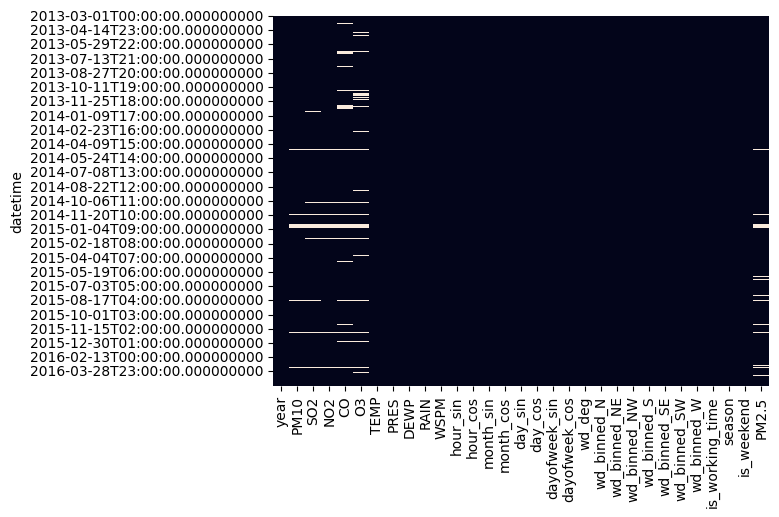

In [12]:
sns.heatmap(df_train.isna(), cbar=False)

Based on the `Little's test`, `chi2` and visual estimation, we may confirm that `MAR` missingness is present in the dataset. Thus, it is possible to build models, interpret and logically impute it.

In [13]:
print("Train nulls:")

train_nulls = get_NA_info(df_train, df_train.columns)
train_nulls

Train nulls:


,Feature,NA Count,Total Count,NA Percentage
0,CO,1647,28051,5.871448
1,O3,1516,28051,5.404442
2,NO2,835,28051,2.976721
3,PM2.5,818,28051,2.916117
4,SO2,816,28051,2.908987
5,PM10,632,28051,2.253039
6,wd_deg,11,28051,0.039214
7,TEMP,2,28051,0.007130
8,PRES,2,28051,0.007130
9,DEWP,2,28051,0.007130


The amount of missing values in `TEMP`, `DEWP`, `PRES`, `RAIN` and `WSPM` invalidates classification and stratification mechanisms (the amount of `NaN`s is less than `2` per feature in train and `18` in test) and therefore, cannot be assigned an imputation model directly, which already sets up the usage of multivariate imputers.

## Can we explain the missingness by something we do observe?

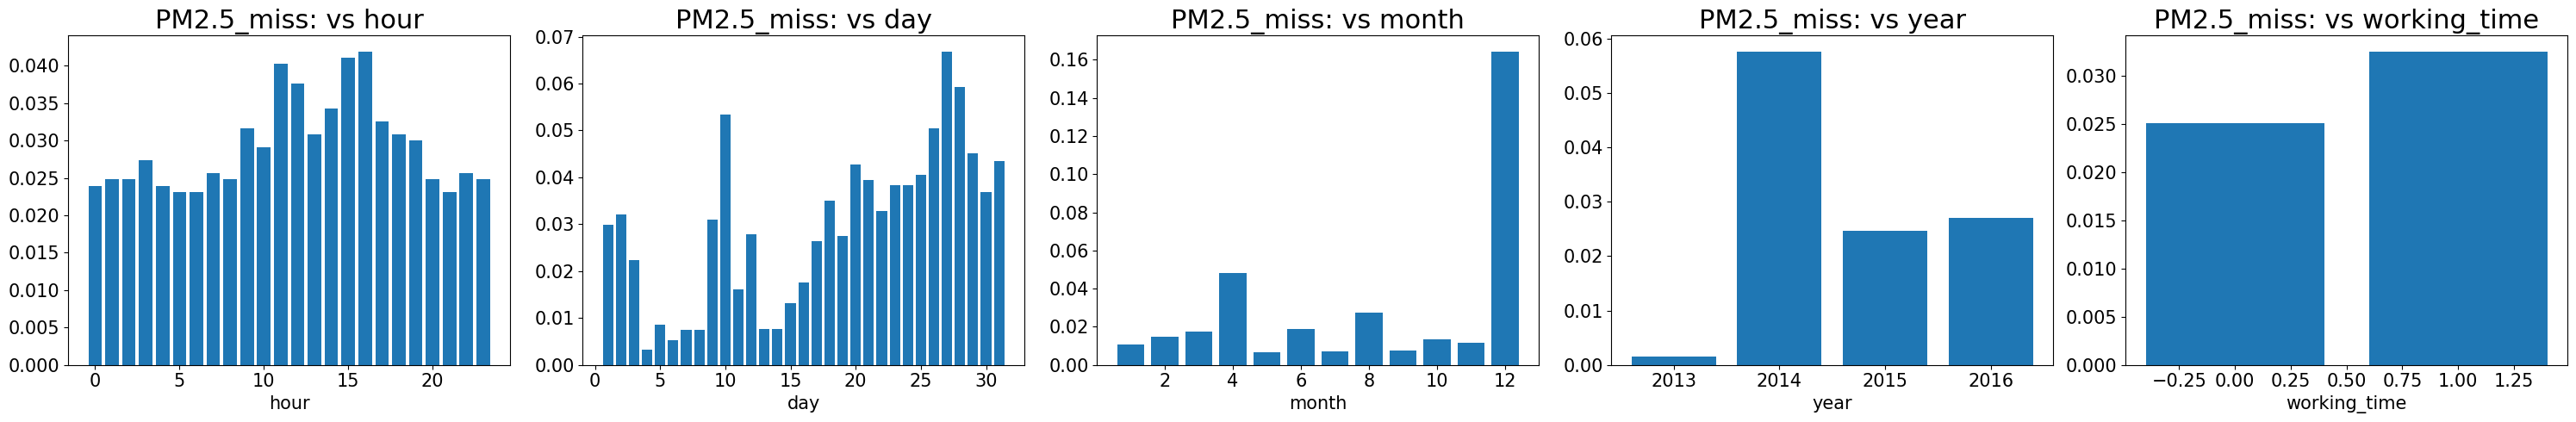

In [14]:
plot_by_time(f"{TARGET}_miss", 
            df_train[TARGET].isna(), {
            'hour': df_train.index.hour, 'day': df_train.index.day, 'month': df_train.index.month, 'year': df_train.index.year, 'working_time': df_train['is_working_time']},
            per_plot_width=6,
            per_plot_height=5,
            title_font_size=22,
            tick_font_size=15
            )

From these generalized plots, there are some questions to answer:
- is PM2.5 missing more frequently during daytime?
- is PM2.5 missing more frequently towards the end of the month?
- does December really has to do something with missingness?
- does winter has anything to do with the missingness?

Let us look if all the above occurs every year:

PM2.5 (2013)


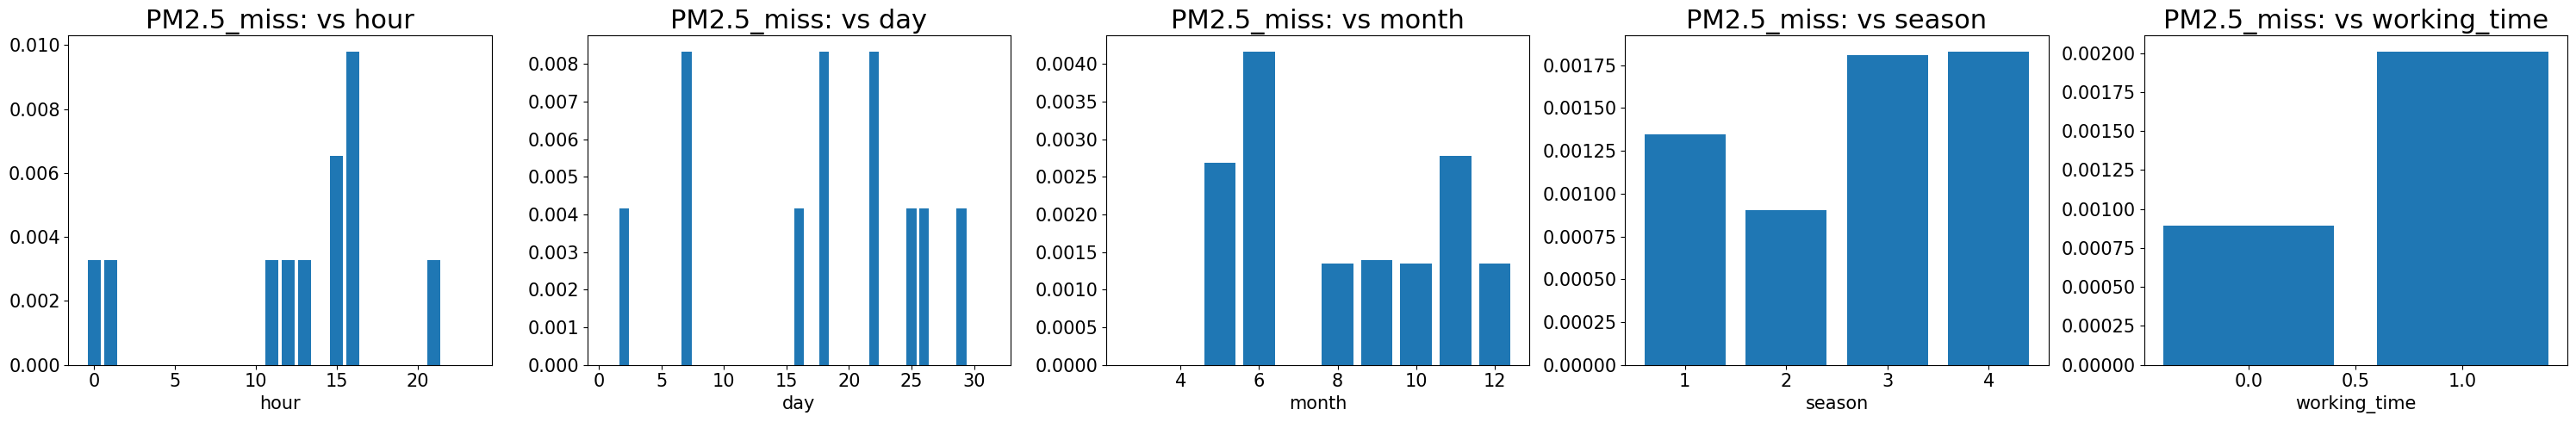

PM2.5 (2014)


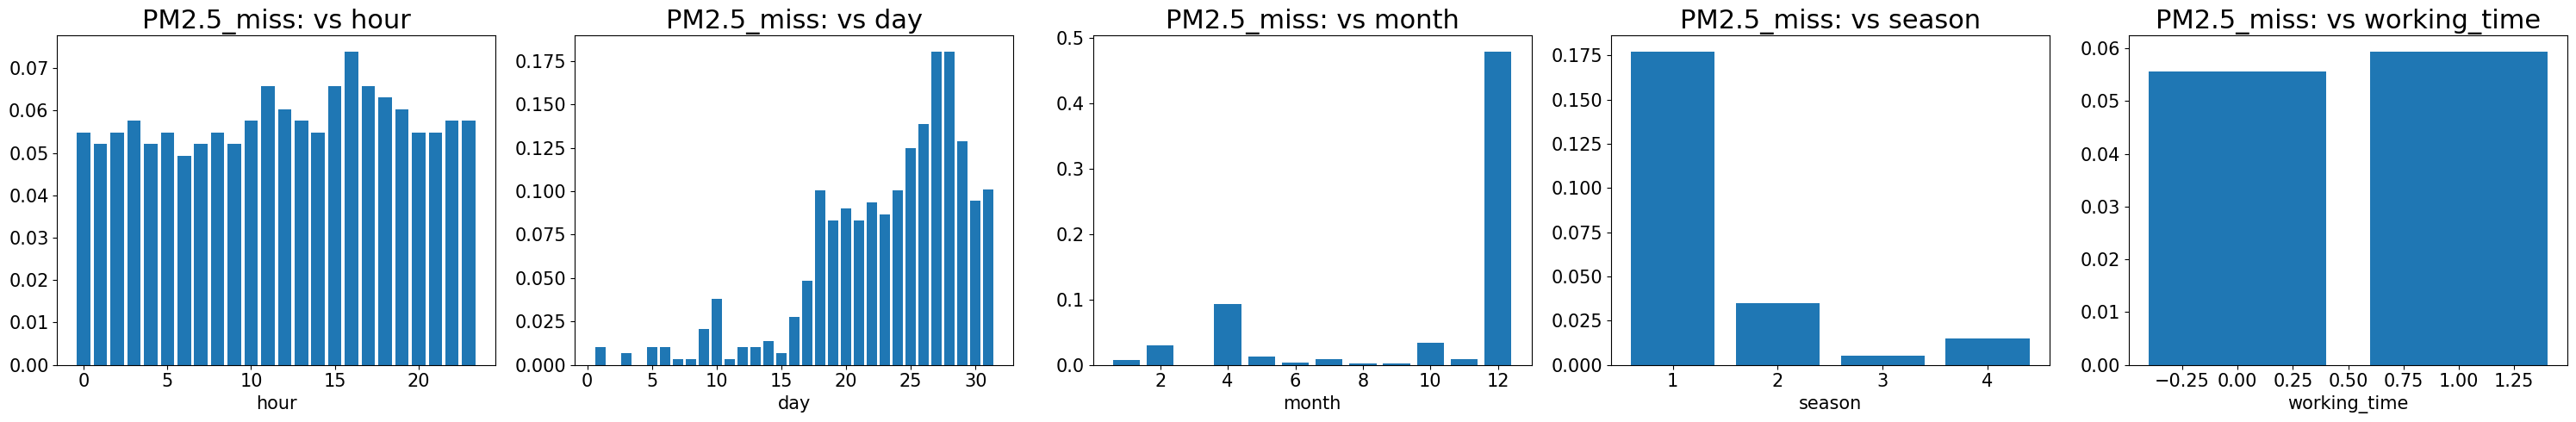

PM2.5 (2015)


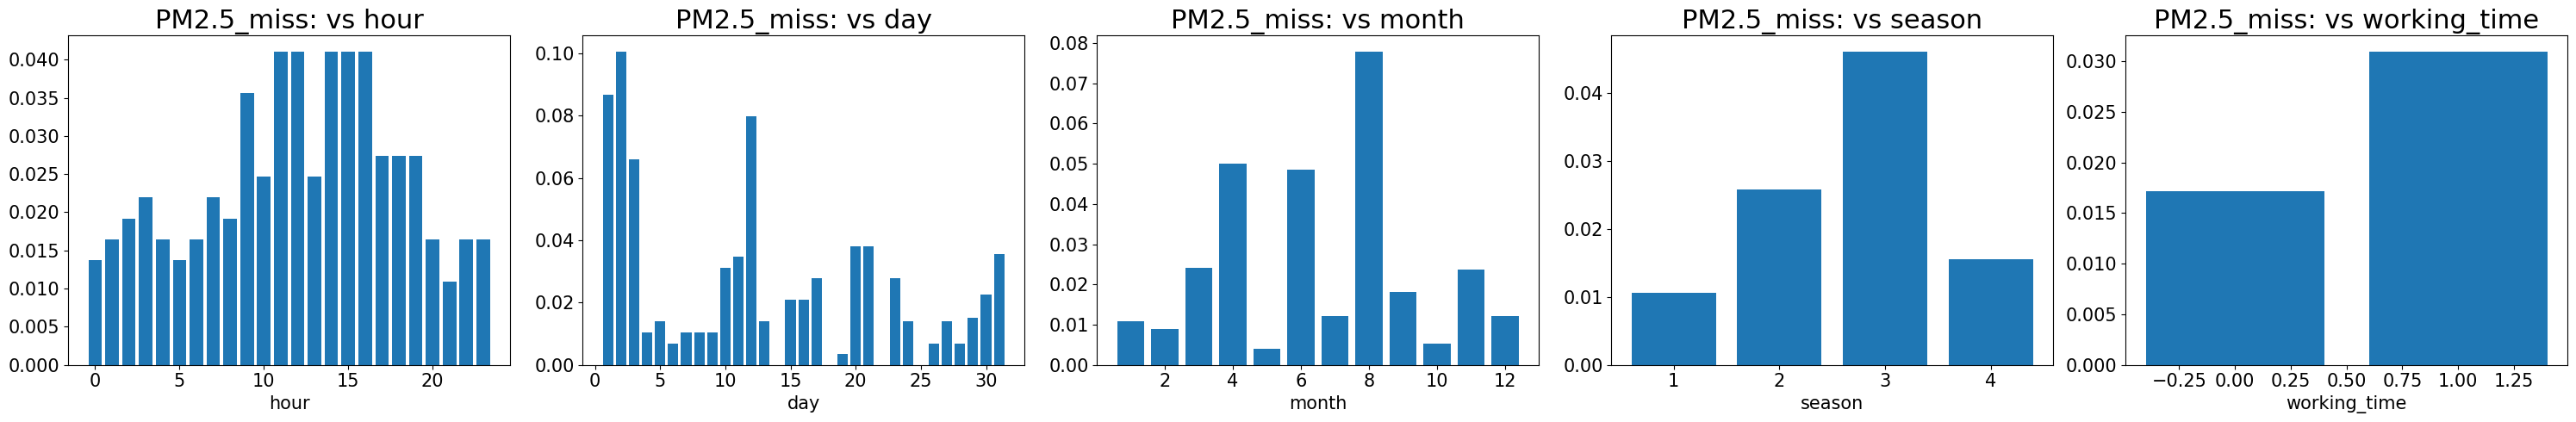

PM2.5 (2016)


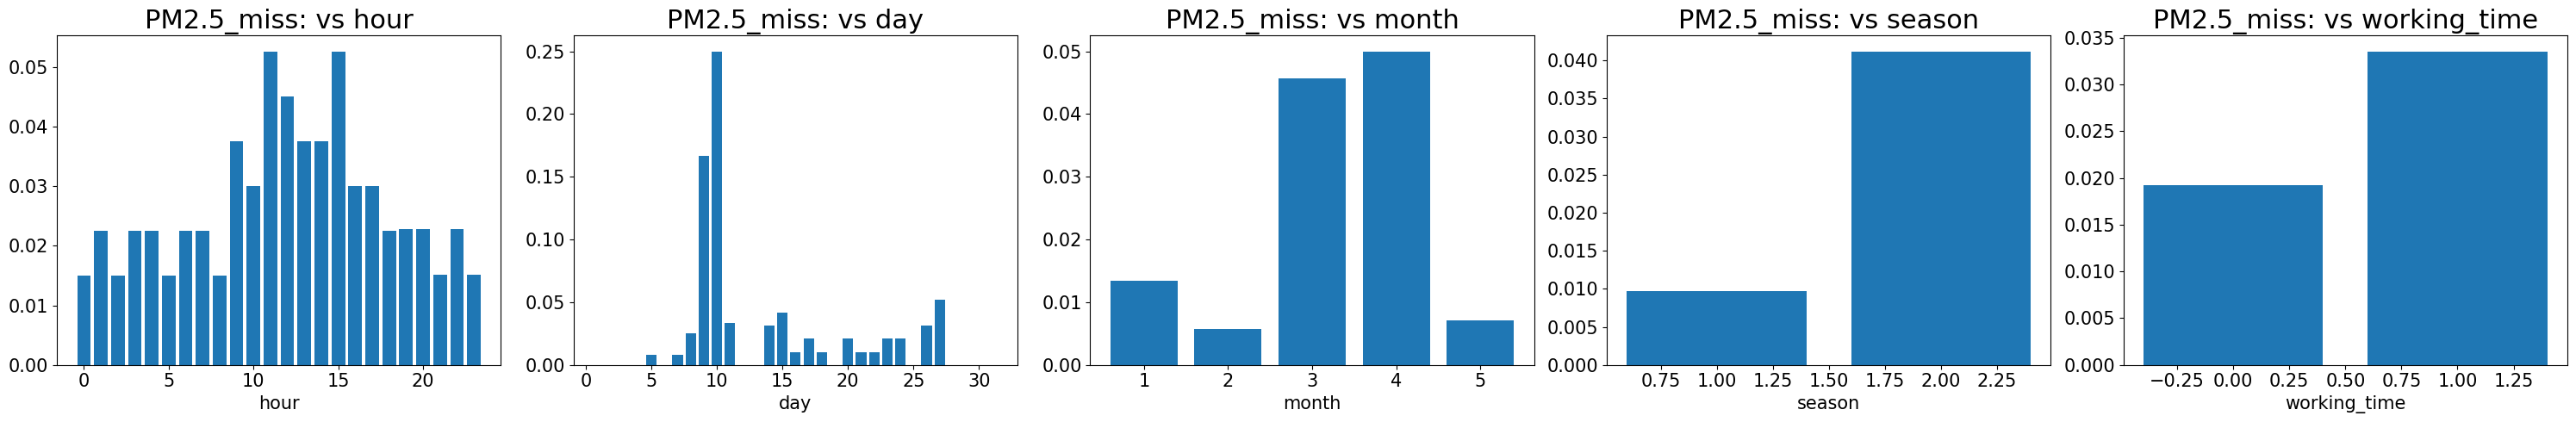

In [15]:
for yr in df_train.index.year.unique().to_list():
    year_filtered_df = df_train[df_train.index.year == yr]
    print(f"{TARGET} ({yr})")
    plot_by_time(f"{TARGET}_miss", 
                year_filtered_df[TARGET].isna(), {
                'hour': year_filtered_df.index.hour, 'day': year_filtered_df.index.day, 'month': year_filtered_df.index.month, 'season': year_filtered_df['season'], 'working_time': year_filtered_df['is_working_time']},
                per_plot_width=6,
                per_plot_height=5,
                title_font_size=22,
                tick_font_size=15
                )

- is PM2.5 missing more frequently during daytime? yes, it is always missing more often during working day, closer to noon.
- is PM2.5 missing more frequently towards the end of the month? no, it is not always the case.
- does December really has to do something with missingness? no, it is not always the case.
- does winter has anything to do with the missingness? no, it is not always the case.

No other clear trends are visible clearly from the plots.

Observing the influence of other features on the missingness, paying attention to temperature:

In [16]:
# no null features, only numerical continuous, no cyclical and no target
non_nulls_numerical = [f for f in continuous_numeric_features if f not in train_nulls.Feature and f != TARGET]
non_nulls_numerical

['year',
 'PM10',
 'SO2',
 'NO2',
 'CO',
 'O3',
 'TEMP',
 'PRES',
 'DEWP',
 'RAIN',
 'WSPM']

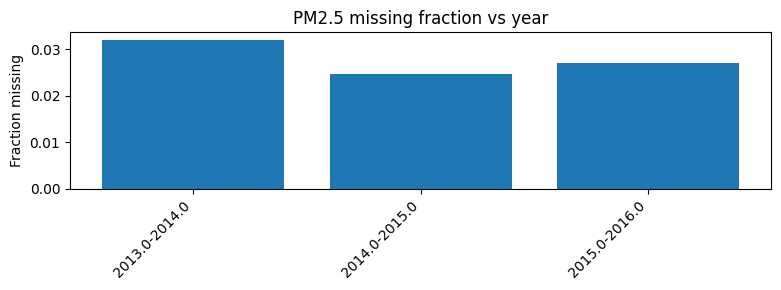

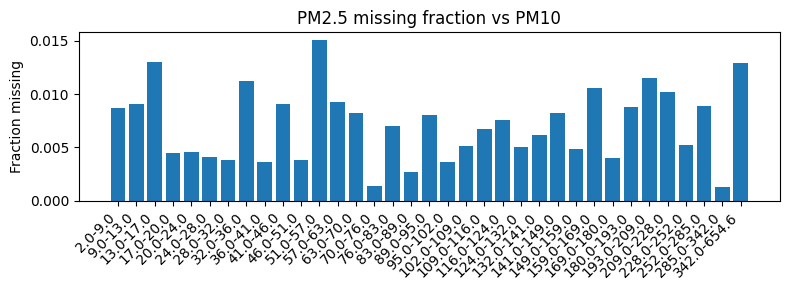

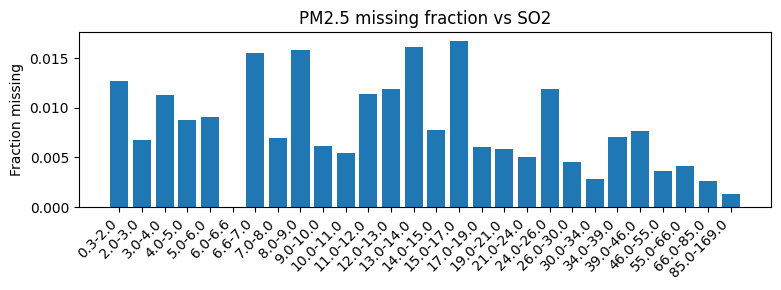

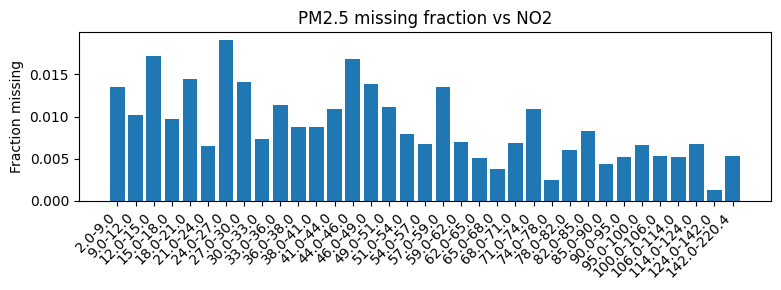

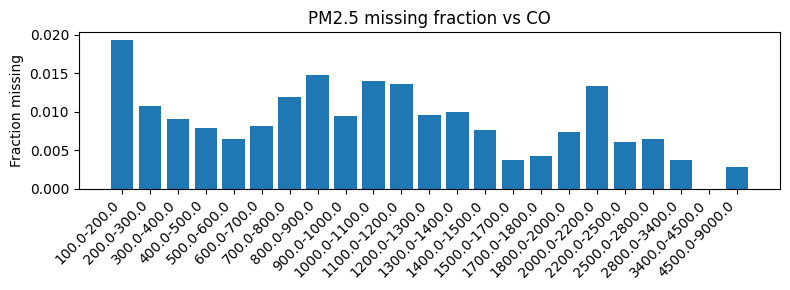

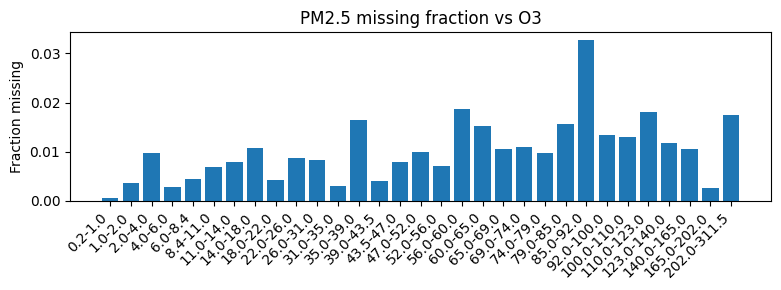

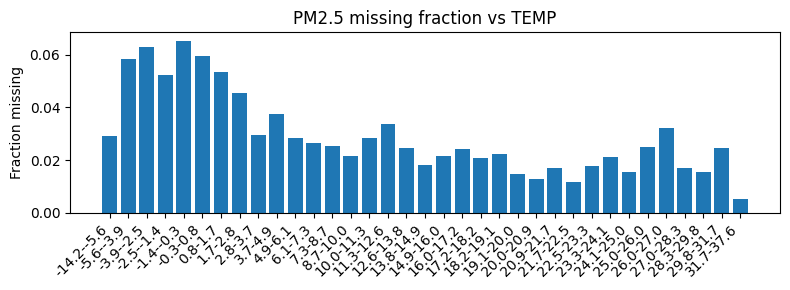

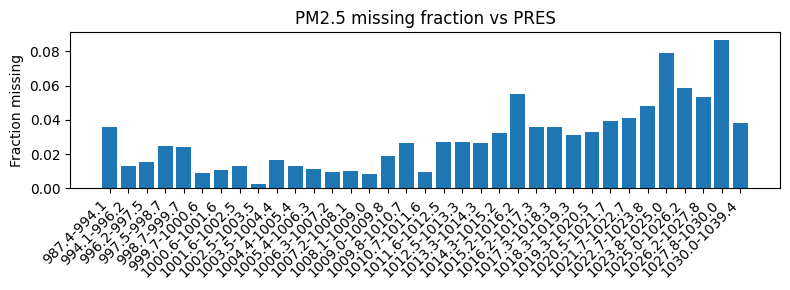

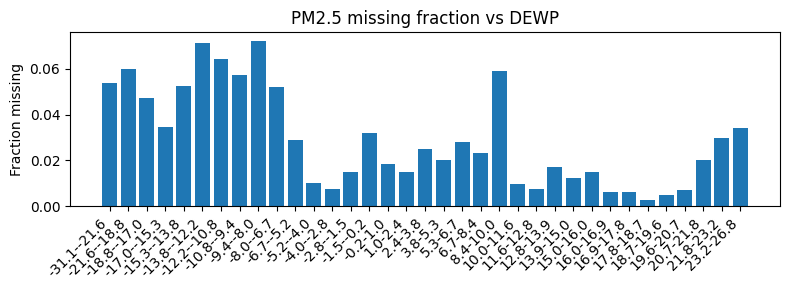

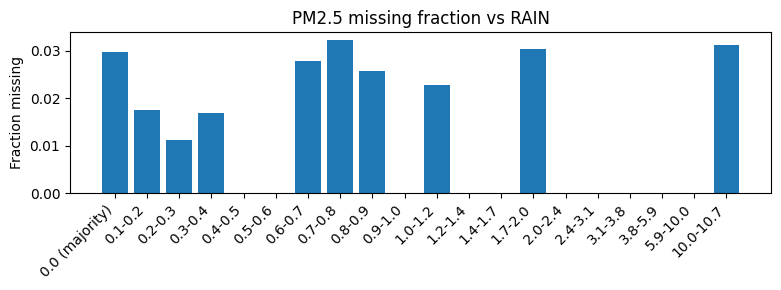

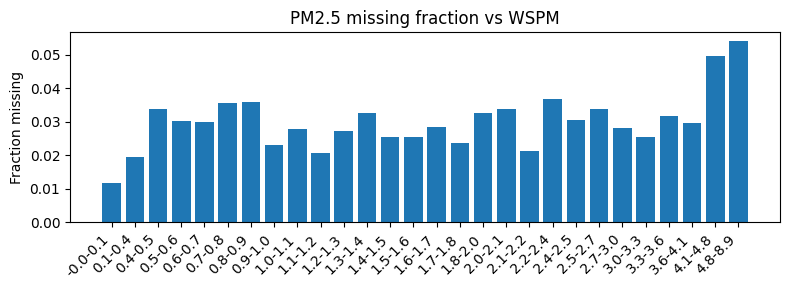

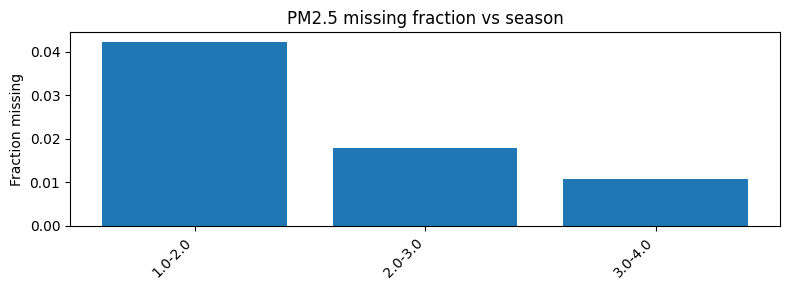

In [18]:
plot_missing_vs_features(df_train, non_nulls_numerical+['season'], TARGET, bins=35)

For lower `TEMP` and `DEWP` (cold, dry air; also for no rain in majority) and high `PRES` (usually linked with stable, stagnant conditions and clear skies) the target is missing more. Possibly, winter harms the sensors (slower fans, condensation/icing if temperature swings, snow particles + wood combustion for heating), dry air also means particles stay very fine and disperse more, which can reduce scattering and make readings harder → more chance of gaps/missingness. High `PRES` (often occurs in winter with temperature inversions) means less mixing of air → more buildup of pollutants near the ground.

The pattern is visible, but it is just a hypothesis. Based on the scatteredness of the plots, the problem is rather more complex and the missingness is driven by many factors simultaneously, some of which are more or less significant. To make it clearer, we are going to build a missingness model, for both imputation and interpretation.

### Classifying the features and preparation for building missingness classification model

In [19]:
train_nulls.Feature.values.tolist()

['CO',
 'O3',
 'NO2',
 'PM2.5',
 'SO2',
 'PM10',
 'wd_deg',
 'TEMP',
 'PRES',
 'DEWP',
 'RAIN',
 'WSPM']

In [20]:
all_features = df_train.columns.tolist()

print(f"All columns ({len(all_features)}): {all_features} \n")
print(f"numerical (cont.) columns ({(len(continuous_numeric_features))}): {continuous_numeric_features})")
print(f"ordinal categorical columns ({len(ordinal_categorical_cols)}): {ordinal_categorical_cols}")
print(f"nominal categorical columns ({len(nominal_categorical_cols)}): {nominal_categorical_cols}\n")

All columns (31): ['year', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'dayofweek_sin', 'dayofweek_cos', 'wd_deg', 'wd_binned_N', 'wd_binned_NE', 'wd_binned_NW', 'wd_binned_S', 'wd_binned_SE', 'wd_binned_SW', 'wd_binned_W', 'is_working_time', 'season', 'is_weekend', 'PM2.5'] 

numerical (cont.) columns (12): ['year', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'PM2.5'])
ordinal categorical columns (4): ['is_working_time', 'season', 'is_weekend', 'wd_deg']
nominal categorical columns (7): ['wd_binned_N', 'wd_binned_NE', 'wd_binned_NW', 'wd_binned_S', 'wd_binned_SE', 'wd_binned_SW', 'wd_binned_W']



Temporarily replacing NaNs in train and test with train statistics to conduct the research:

In [21]:
train_num_medians = X_train[non_nulls_numerical].median()
train_cat_medians = X_train[['wd_deg']].mode().iloc[0]

X_train[non_nulls_numerical] = X_train[non_nulls_numerical].fillna(train_num_medians)
X_train[['wd_deg']] = X_train[['wd_deg']].fillna(train_cat_medians)

X_test[non_nulls_numerical] = X_test[non_nulls_numerical].fillna(train_num_medians)
X_test[['wd_deg']] = X_test[['wd_deg']].fillna(train_cat_medians)

In [22]:
print("X_train:")
display(get_NA_info(X_train, X_train.columns.tolist()))

print("X_test:")
display(get_NA_info(X_test, X_test.columns.tolist()))

X_train:
No missing values are found in the dataframe


[]

X_test:
No missing values are found in the dataframe


[]

Composing the target for classification. We must also exclude the raw feature (`PM2.5`) or any of its derivatives from the predictors - keeping them would leak the truth we are trying to predict:

In [23]:
CLASS_TARGET = f'{TARGET}_miss'

# classification targets for both sets
y_train_class = pd.Series(y_train.isna(), dtype=int, name=CLASS_TARGET)
y_test_class = pd.Series(y_test.isna(), dtype=int, name=CLASS_TARGET)

### Assumption validation

#### Sufficient overlap and data

In [24]:
class_target_val_counts = y_train_class.value_counts()
display(class_target_val_counts)

print(f"Value '{class_target_val_counts.index[0]}': {class_target_val_counts.values[0]} / {len(y_train_class)} ({(class_target_val_counts.values[0] / len(y_train_class)) * 100:.2f}%)")
print(f"Value '{class_target_val_counts.index[1]}': {class_target_val_counts.values[1]} / {len(y_train_class)} ({(class_target_val_counts.values[1] / len(y_train_class)) * 100:.2f}%)")

PM2.5_miss
0    27233
1      818
Name: count, dtype: int64

Value '0': 27233 / 28051 (97.08%)
Value '1': 818 / 28051 (2.92%)


Once again, we are dealing with a classification problem. The target is significantly skewed towards non-missing values (97.1 / 2.9 %). In other words, if we fit any learning model, it probably would predict "non-missing" most of the times, therefore making interpretation (the goal of the model being created) of the coefficients irrelevant. 

To account for that, we perform custom weighting by equalizing both classes:

In [25]:
# entry qty of each class
n_missing = y_train_class.sum()
n_non_missing = len(y_train_class) - n_missing

# re-weighting each class to take 50% impact
weight_missing = 0.5 / (n_missing / len(y_train_class))
weight_non_missing = 0.5 / (n_non_missing / len(y_train_class))

print("'missing' class weight = ", weight_missing)
print("'non_missing' class weight = ", weight_non_missing)

# construct an array of respective weights for each target value
weights = np.where(y_train_class == 1, weight_missing, weight_non_missing)
print("\nweights =", weights)
print("weights.shape =", weights.shape)

'missing' class weight =  17.1460880195599
'non_missing' class weight =  0.5150185436786252

weights = [0.51501854 0.51501854 0.51501854 ... 0.51501854 0.51501854 0.51501854]
weights.shape = (28051,)


#### Perfect / high multicollinearity

Although optional for classification predictions (black-box-wise), it is necessary for stable and successful fitting and interpretation. The reasons to consider the assumption:
- interpretation of missingness is necessary and `p-values` become meaningless when standard errors are inflated
- we need to fit a stable model to perform other inspections (`Breusch-Pagan`, `Durbin-Watson` etc.), but the coefficients become unstable and change wildly with small data perturbations given high collinearity
- perfect multicollinearity may break model fitting due to inverse matrix computation

In [26]:
detect_perfect_multicollinearity_via_rank(dataframe=X_train, target=CLASS_TARGET, verbose=True)

Matrix rank: 30 / 30 features


(False, 30)

In [27]:
vif_table = perform_VIF(data_frame_no_nulls=X_train, 
            encoded_predictors=list(X_train.columns), 
            target=CLASS_TARGET
            )

vif_table.head(10)

,feature,VIF
20,wd_deg,12484.517644
26,wd_binned_SW,3195.555343
23,wd_binned_NW,3041.597806
27,wd_binned_W,2683.267511
21,wd_binned_N,1540.385536
24,wd_binned_S,887.418863
22,wd_binned_NE,487.683418
25,wd_binned_SE,148.682089
7,TEMP,11.810991
9,DEWP,9.390467


Near-perfect multicollinearity in `wd` is present due to having been encoded as both ordinal and nominal. The extra relation is redundant, should be eliminated.

In [28]:
X_train = X_train.drop(columns=['wd_deg'])
X_test = X_test.drop(columns=['wd_deg'])

In [29]:
vif_table = perform_VIF(data_frame_no_nulls=X_train, 
            encoded_predictors=list(X_train.columns), 
            target=CLASS_TARGET
            )

vif_table.head(10)

,feature,VIF
7,TEMP,11.810976
9,DEWP,9.390445
15,month_cos,8.286420
14,month_sin,5.952734
13,hour_cos,5.777489
27,is_working_time,5.203772
8,PRES,4.584573
4,NO2,3.421159
28,season,3.137963
5,CO,2.944829


In [30]:
get_VIF_features_to_drop(X_train, TARGET, 5.0)

['before dropping anything: 11.810976178801416',
 'after dropping TEMP: 8.51211386824141',
 'after dropping DEWP: 5.364875698930875',
 'after dropping hour_cos: 4.259912601028595']

No evidence of **perfect** multicollinearity was found (full rank; no infinites in VIF). The highest VIF score is `TEMP = 11.81`, which is, according to the standard VIF interpretation, considered troublesome. As the overall missingness imputation concept implies, we should retain as much information as possible. 

As the additional VIF analysis suggests, dropping one feature also doesn't resolve the inflation and furthermore, doesn't guarantee sustainable VIF stability across the following tests, which doesn't make any candidates for dropping. It is intended to initiate an investigation towards `TEMP`, `DEWP`, `month_sin`, `month_cos`, `hour_cos` and `is_working_time` (VIF > 5).

- `TEMP` may be important both directly and indirectly, being a base indicator for `seasons`, `humidity`, `wind` and other unobvious interconnected dependencies and (hypothetically) other `MNAR` parameters.
- higher `humidity` (higher `DEWP` generally indicates higher relative `humidity`) can promote the condensation of water vapor onto existing particulate matter, increasing its size. This makes `PM2.5` more likely to be detected as such. With that being said, `TEMP` as the kinetic energy of air molecules and `DEWP` being the amount of water vapor in the air, bear different information thus are related, not identical. Both have to be retained.
- `month_sin`, `month_cos`, `hour_cos`, `is_working_time` are time-related features that reflect trends and is one of the most crucial determiners of when the plants (presumably) start to leak emissions into the air. Dropping is not considered as well.

The caveat is, however, that while the domain studies' claims to justify keeping all features is acceptable for feature selection, it does not remove the statistical problem of multicollinearity for coefficient interpretation, which we will inevitably need to explain the missingness.

All the above has led us to the choice of either a faster one or more "coefficient-friendly" solution - residualizing.

In the first case, we would retain all, use `L2 regularization` to reduce the coefficient variance while using permutation importance for interpretability to account for the remaining variance. For the second, we would residualize less important feature by removing the shared linear part between the two (to reach orthogonality). The second solution is chosen to favor interpretability.

##### Residualization

In the domain, within the context of residualization, `DEWP` is taken as the one that should be preserved raw. It measures specific temperature responsible for condensation, it is more nuanced than the general air temperature. Therefore, `TEMP` is going to be residualized.

In [31]:
dot_products, \
residualized_temp_train, \
residualized_temp_test = residualize(dataframe_train_encoded=X_train,
                            dataframe_test_encoded=X_test, 
                            feat_to_residualize="TEMP", 
                            feat_to_residualize_on=["DEWP"]
                            )

In [32]:
dot_products

DEWP   -2.693560e-08
dtype: float64

The specified default tolerance is `1e-8`. The dot product is smaller. To confirm successful residualization, we check the correlation between the two features involved. If the linearity between them is eliminated, it should be close to `0`.

In [33]:
np.corrcoef(residualized_temp_train, X_train["DEWP"])[0,1]

-1.0860866238599031e-14

Successful residualization confirmed.

In [34]:
# Applying the residualized
X_train['TEMP_residual'] = residualized_temp_train 
X_test['TEMP_residual'] = residualized_temp_test

# Drop original TEMP and use TEMP_residual instead 
X_train = X_train.drop(columns=["TEMP"]) 
X_test = X_test.drop(columns=["TEMP"])

In [35]:
detect_perfect_multicollinearity_via_rank(dataframe=X_train, target=CLASS_TARGET, verbose=True)

Matrix rank: 29 / 29 features


(False, 29)

In [36]:
vif_table_diag = perform_VIF(data_frame_no_nulls=X_train, 
            encoded_predictors=list(X_train.columns), 
            target=CLASS_TARGET   
            )

vif_table_diag.head(10)

,feature,VIF
8,DEWP,11.954604
14,month_cos,8.286420
13,month_sin,5.952734
12,hour_cos,5.777489
26,is_working_time,5.203772
7,PRES,4.584573
29,TEMP_residual,4.012428
4,NO2,3.421159
27,season,3.137963
5,CO,2.944829


In [37]:
get_VIF_features_to_drop(X_train, TARGET, 5.0)

['before dropping anything: 11.954604034118244',
 'after dropping DEWP: 5.645959651549652',
 'after dropping hour_cos: 4.3137733847079955']

By performing rank deficiency check and VIF on the modified `df_train_class`, we confirm that the collinearity is still too high, this time for `DEWP` = `11.95`. Residualizing again: `month_cos` on `DEWP` in favor of `DEWP` this time.

In [38]:
dot_products, \
residualized_month_cos_train, \
residualized_month_cos_test = residualize(dataframe_train_encoded=X_train,
                                            dataframe_test_encoded=X_test, 
                                            feat_to_residualize="month_cos", 
                                            feat_to_residualize_on=["DEWP"]
                                            )

Residualizing succeeded: orthogonality achieved (within numerical tolerance).


In [39]:
# Applying the residualized
X_train['month_cos_residual'] = residualized_month_cos_train 
X_test['month_cos_residual'] = residualized_month_cos_test 

# Drop original TEMP and use TEMP_residual instead 
X_train = X_train.drop(columns=["month_cos"]) 
X_test = X_test.drop(columns=["month_cos"])

In [40]:
detect_perfect_multicollinearity_via_rank(dataframe=X_train, target=CLASS_TARGET, verbose=True)

Matrix rank: 29 / 29 features


(False, 29)

In [41]:
vif_table_diag = perform_VIF(data_frame_no_nulls=X_train, 
            encoded_predictors=list(X_train.columns), 
            target=CLASS_TARGET   
            )

vif_table_diag.head(10)

,feature,VIF
8,DEWP,6.418098
13,month_sin,5.952734
12,hour_cos,5.777489
25,is_working_time,5.203772
7,PRES,4.584573
29,month_cos_residual,4.432105
28,TEMP_residual,4.012428
4,NO2,3.421159
26,season,3.137963
5,CO,2.944829


Current highest `VIF` = `6.4`. It's classified as high and still needs research, further residualization is unnecessary as multicollinearity isn't that severe anymore (`VIF` < 10). The current score only raises suspicions and needs research. For investigation, coefficient stability via bootstrap is going to be used.

Checking pair-wise Pearson correlations with a threshold of `0.7` (looking for answers in linear dependencies):

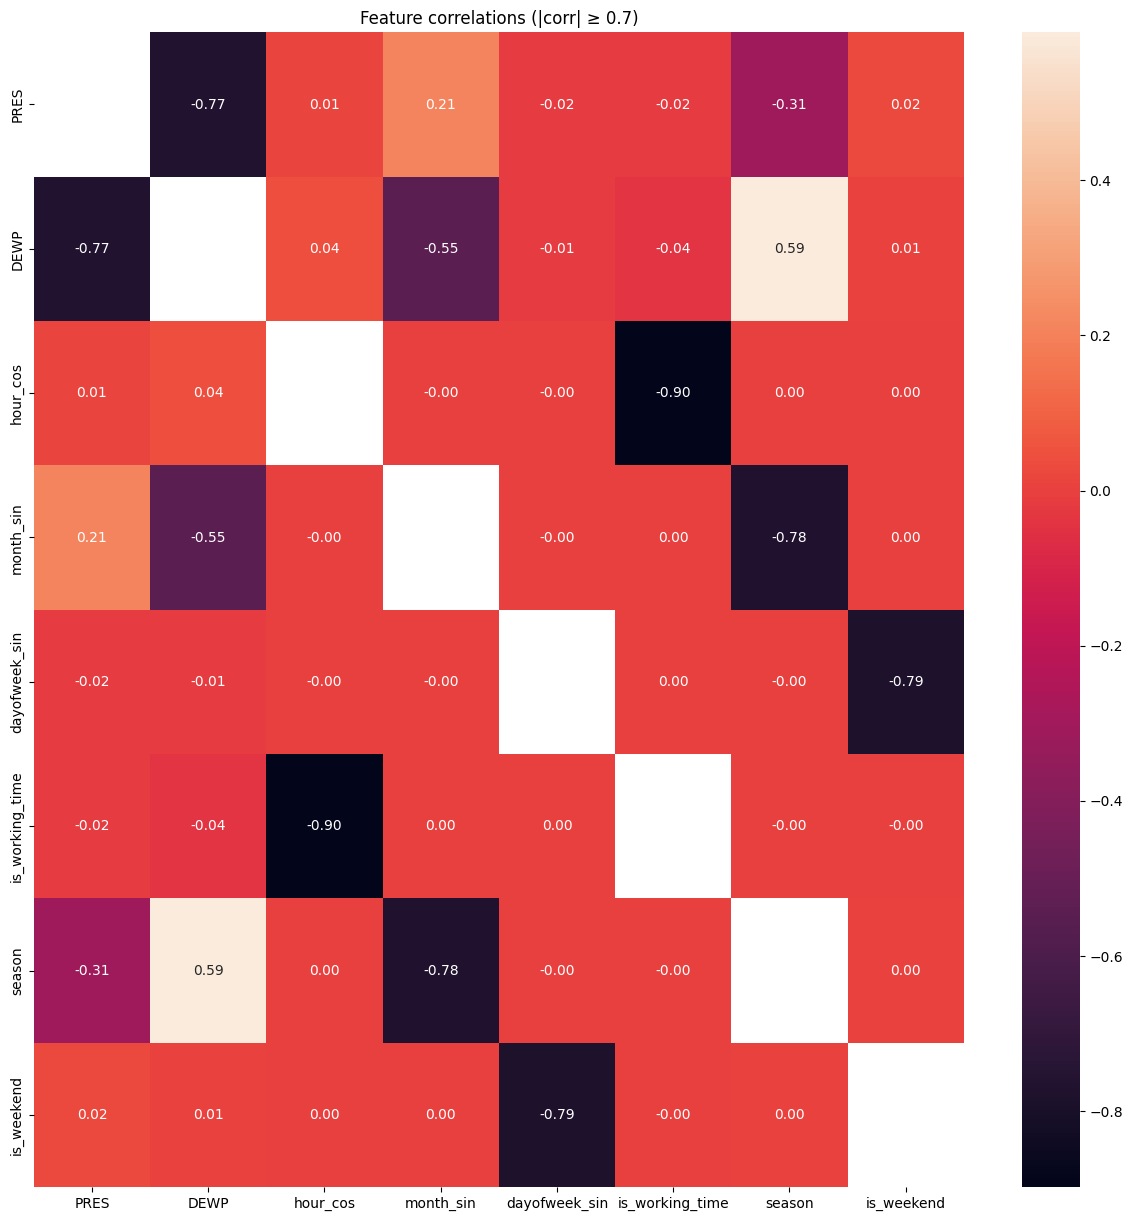

In [42]:
df_train_class = pd.concat([X_train, y_train_class], axis=1)
correlations = plot_correlations(df_train_class, df_train_class.columns.tolist(), f'Feature correlations', 0.7)

One of the high-correlation combinations is `hour_cos` and `is_working_time`. Their respective VIFs are `5.77` and `5.2`, which are not significant, but in the suspicious zone. And `Pearson`'s coefficient of `-0.9`confirms those suspicions. Dropping of `hour_cos` might be considered dut to `is_working_time`'s being easier to understand and interpret, but `hour_cos` can carry more cyclical information for the model. Therefore, it is better to combine them into one `working_hour_component` saying "we only care about the cyclical effect of hours during working time":

In [43]:
X_train['working_hour_component'] = X_train['is_working_time'] * X_train['hour_cos']
X_test['working_hour_component'] = X_test['is_working_time'] * X_test['hour_cos']

X_train = X_train.drop(columns=["is_working_time", "hour_cos"])
X_test = X_test.drop(columns=["is_working_time", "hour_cos"])

In [44]:
vif_table_diag = perform_VIF(data_frame_no_nulls=X_train, 
            encoded_predictors=list(X_train.columns), 
            target=CLASS_TARGET   
            )

vif_table_diag.head(10)

,feature,VIF
8,DEWP,6.492863
12,month_sin,5.948270
7,PRES,4.620254
27,month_cos_residual,4.417987
26,TEMP_residual,4.131847
4,NO2,3.411197
24,season,3.139018
5,CO,2.951264
25,is_weekend,2.858831
15,dayofweek_sin,2.766685


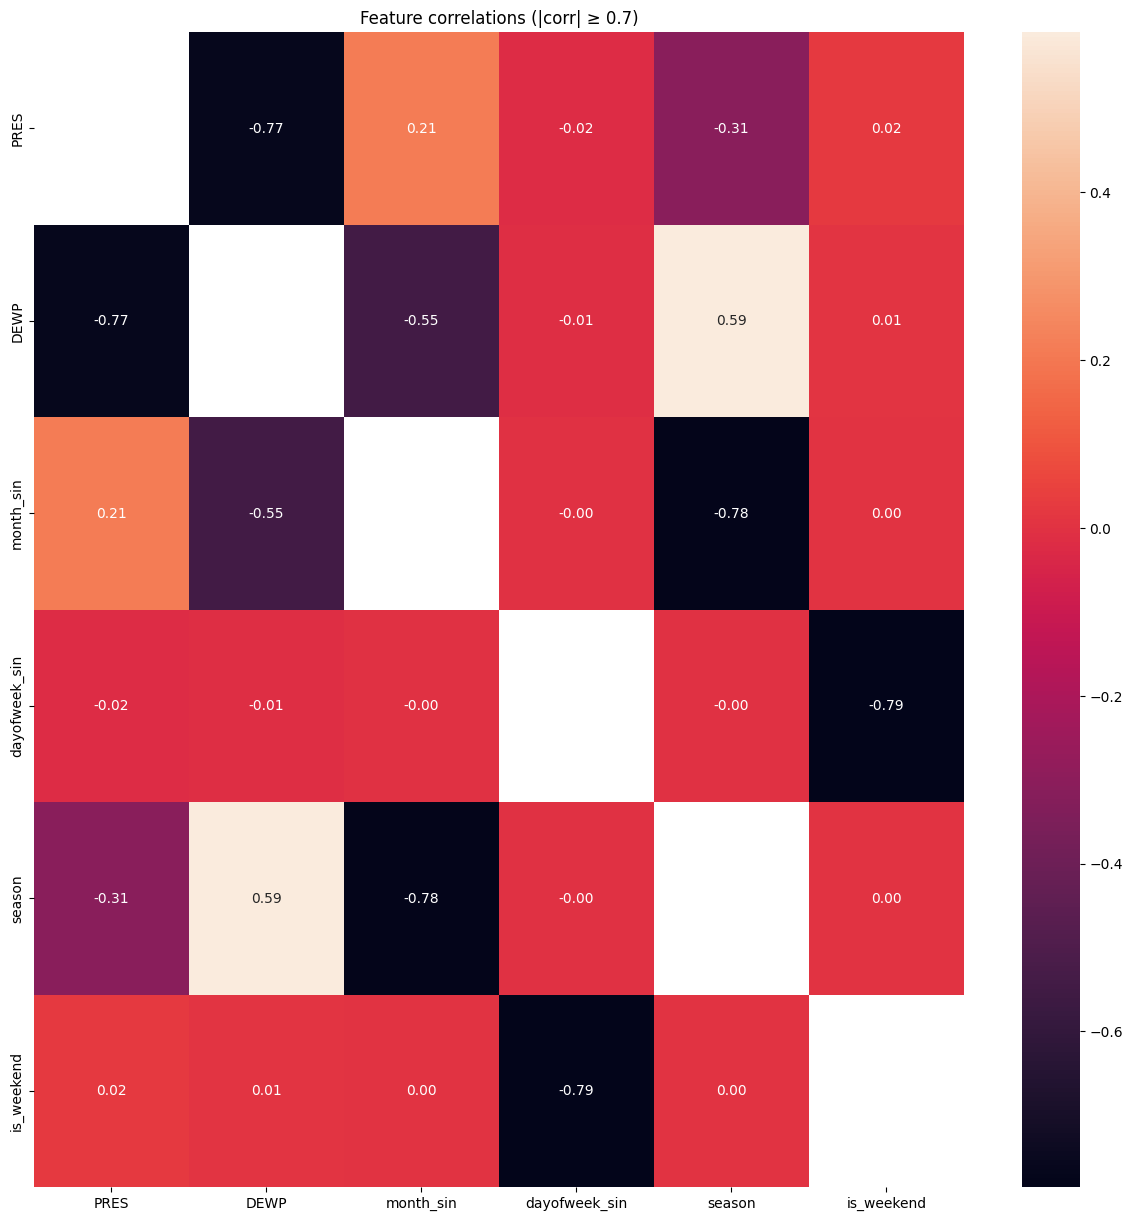

In [45]:
df_train_class = pd.concat([X_train, y_train_class], axis=1)
correlations = plot_correlations(df_train_class, df_train_class.columns.tolist(), f'Feature correlations', 0.7)

Another pair is `PRES` and `DEWP`. Pressure and dew point have a [direct relationship](https://en.wikipedia.org/wiki/Dew_point#:~:text=Increasing%20the%20barometric%20pressure%20raises,will%20be%20greater%20in%20Denver.): for a given amount of water vapor, higher atmospheric pressure leads to a higher dew point. But they different measures and may have unique contributions. To visually judge if they behave redundantly in the given dataset, we build a scatterplot of their relationship colored by the missingness:

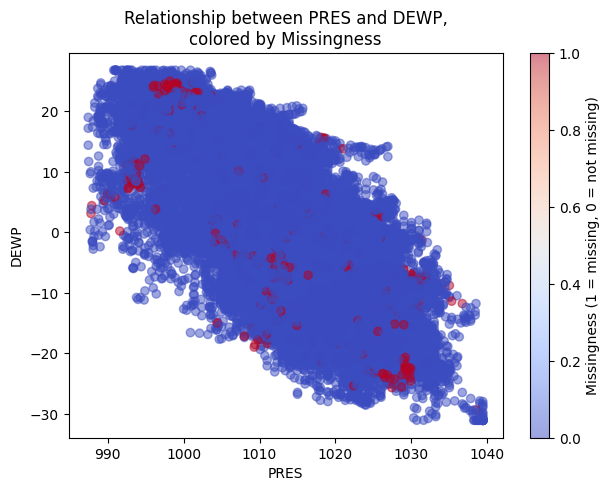

In [46]:
plot_scatter_relationship_colored_by_missingness(X_train, 'PRES', 'DEWP', y_train_class)

The scatter is not a straight line, the color patterns don't depend on one axis, thus, `PRES` and `DEWP` both may contribute uniquely, dropping or residualizing is not considered.

Combining them into a mixing ratio (kg water vapor per kg dry air) is being added.

In [47]:
def mixing_ratio(T_dew_c, p_hpa):
    """
    Compute mixing ratio (kg water vapor per kg dry air) from dew point and pressure.
    Inputs:
        T_dew_c : dew point in °C
        p_hpa   : ambient pressure in hPa
    Returns:
        w : mixing ratio (kg/kg)
    """
    e = 6.112 * np.exp((17.62 * T_dew_c) / (243.12 + T_dew_c))  # hPa
    return 0.622 * e / (p_hpa - e)

In [48]:
X_train['DEWP_per_PRES'] = mixing_ratio(X_train['DEWP'], X_train['PRES'])
X_test['DEWP_per_PRES'] = mixing_ratio(X_test['DEWP'], X_test['PRES'])

Checking if we need to remove both `DEWP` and `PRES` now:

In [49]:
get_VIF_features_to_drop(X_train, TARGET, 5.0)

['before dropping anything: 15.335926342452314',
 'after dropping DEWP: 6.9353702268113695',
 'after dropping month_sin: 3.843837635958661']

We may only drop `DEWP`:

In [50]:
X_train = X_train.drop(columns=['DEWP'])
X_test = X_test.drop(columns=['DEWP'])

In [51]:
vif_table_diag = perform_VIF(data_frame_no_nulls=X_train, 
            encoded_predictors=list(X_train.columns), 
            target=CLASS_TARGET   
            )

vif_table_diag.head(10)

,feature,VIF
11,month_sin,6.935370
28,DEWP_per_PRES,4.982452
26,month_cos_residual,4.601822
25,TEMP_residual,4.060599
7,PRES,3.767317
4,NO2,3.384257
23,season,3.023300
5,CO,2.948648
24,is_weekend,2.859232
14,dayofweek_sin,2.766304


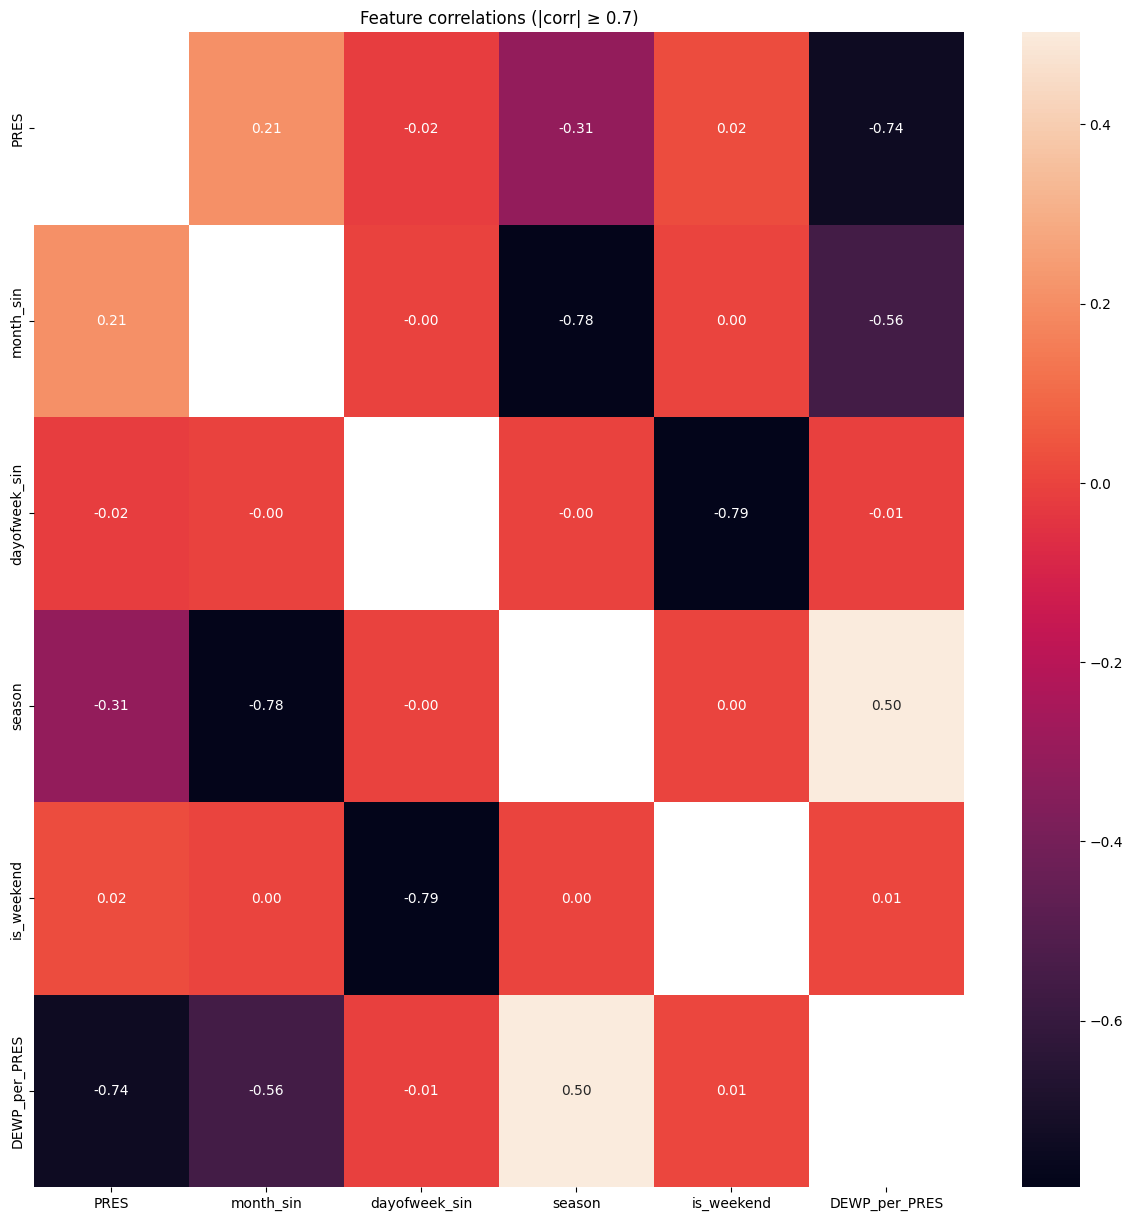

In [52]:
df_train_class = pd.concat([X_train, y_train_class], axis=1)
correlations = plot_correlations(df_train_class, df_train_class.columns.tolist(), f'Feature correlations', 0.7)

The next pair is `season` vs `month_sin`. The situation is similar to the one with `hour_cos` and `is_working_time`, but this time they are both calender phenomena only bound to nature and since `is_working_time` is easier to interpret, `month_sin` is going to be dropped.

In [53]:
X_train = X_train.drop(columns=["month_sin"])
X_test = X_test.drop(columns=["month_sin"])

In [54]:
vif_table_diag = perform_VIF(data_frame_no_nulls=X_train, 
            encoded_predictors=list(X_train.columns), 
            target=CLASS_TARGET   
            )

vif_table_diag.head(10)

,feature,VIF
27,DEWP_per_PRES,3.843838
7,PRES,3.733316
24,TEMP_residual,3.678472
4,NO2,3.379776
5,CO,2.923076
23,is_weekend,2.859068
13,dayofweek_sin,2.766208
6,O3,2.749105
16,wd_binned_NE,2.473981
25,month_cos_residual,2.434672


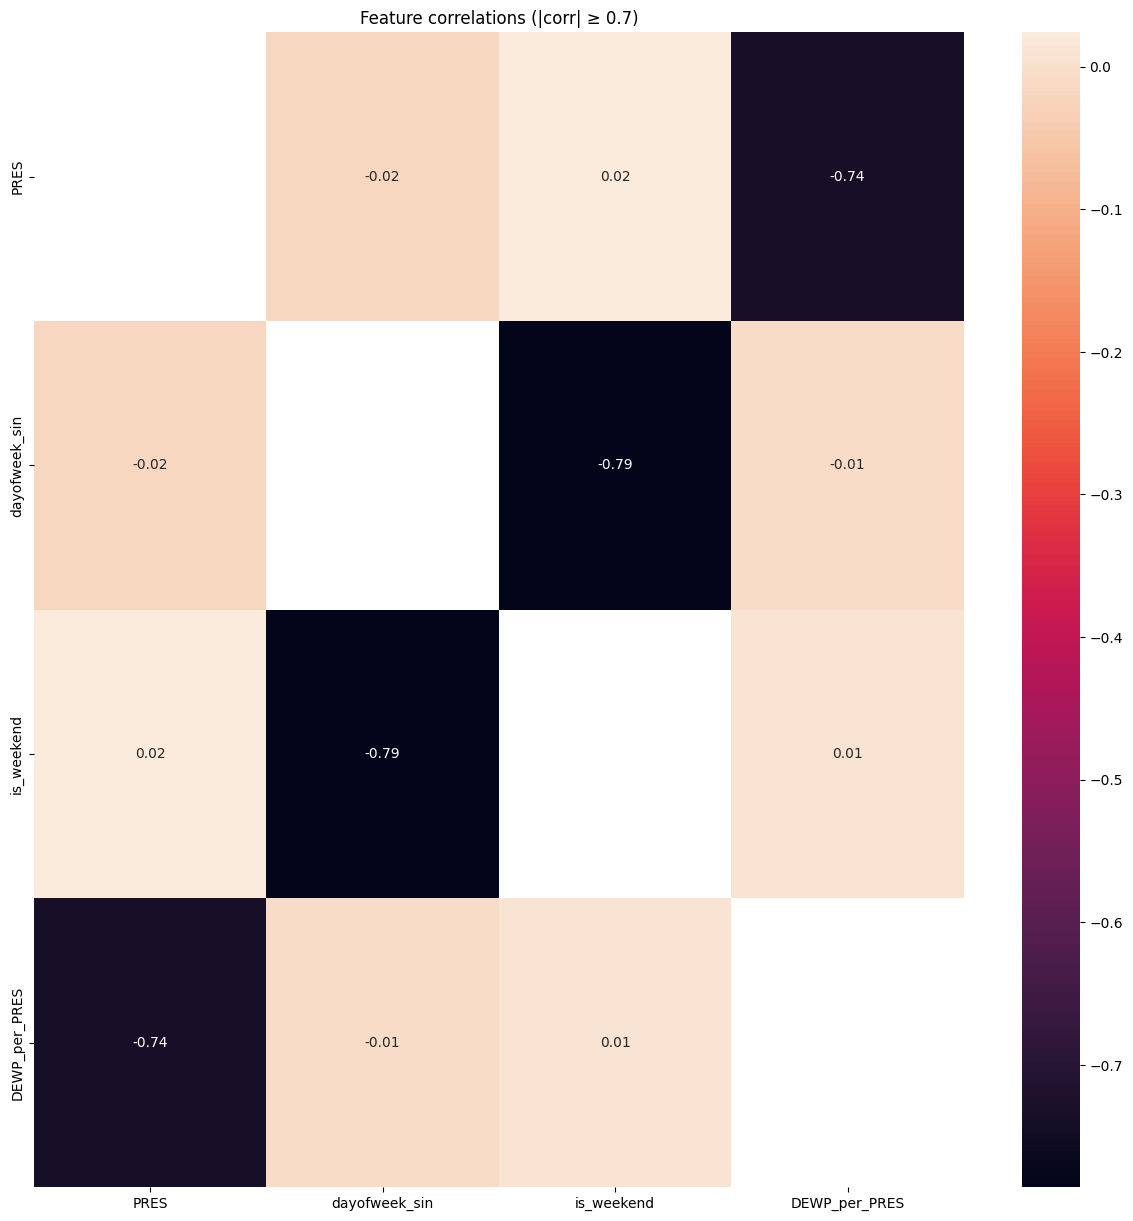

In [55]:
df_train_class = pd.concat([X_train, y_train_class], axis=1)
correlations = plot_correlations(df_train_class, df_train_class.columns.tolist(), f'Feature correlations', 0.7)

The pair of `is_weekend` and `dayofweek_sin` also refers to the same concept of a week. The less interpretable (`dayofweek_sin`) is dropped.

In [56]:
X_train = X_train.drop(columns=["dayofweek_sin"])
X_test = X_test.drop(columns=["dayofweek_sin"])

In [57]:
vif_table_diag = perform_VIF(data_frame_no_nulls=X_train, 
            encoded_predictors=list(X_train.columns), 
            target=CLASS_TARGET   
            )

vif_table_diag.head(10)

,feature,VIF
26,DEWP_per_PRES,3.843800
7,PRES,3.733284
23,TEMP_residual,3.678316
4,NO2,3.379495
5,CO,2.923003
6,O3,2.748982
15,wd_binned_NE,2.473026
24,month_cos_residual,2.434626
14,wd_binned_N,2.369435
2,PM10,2.286676


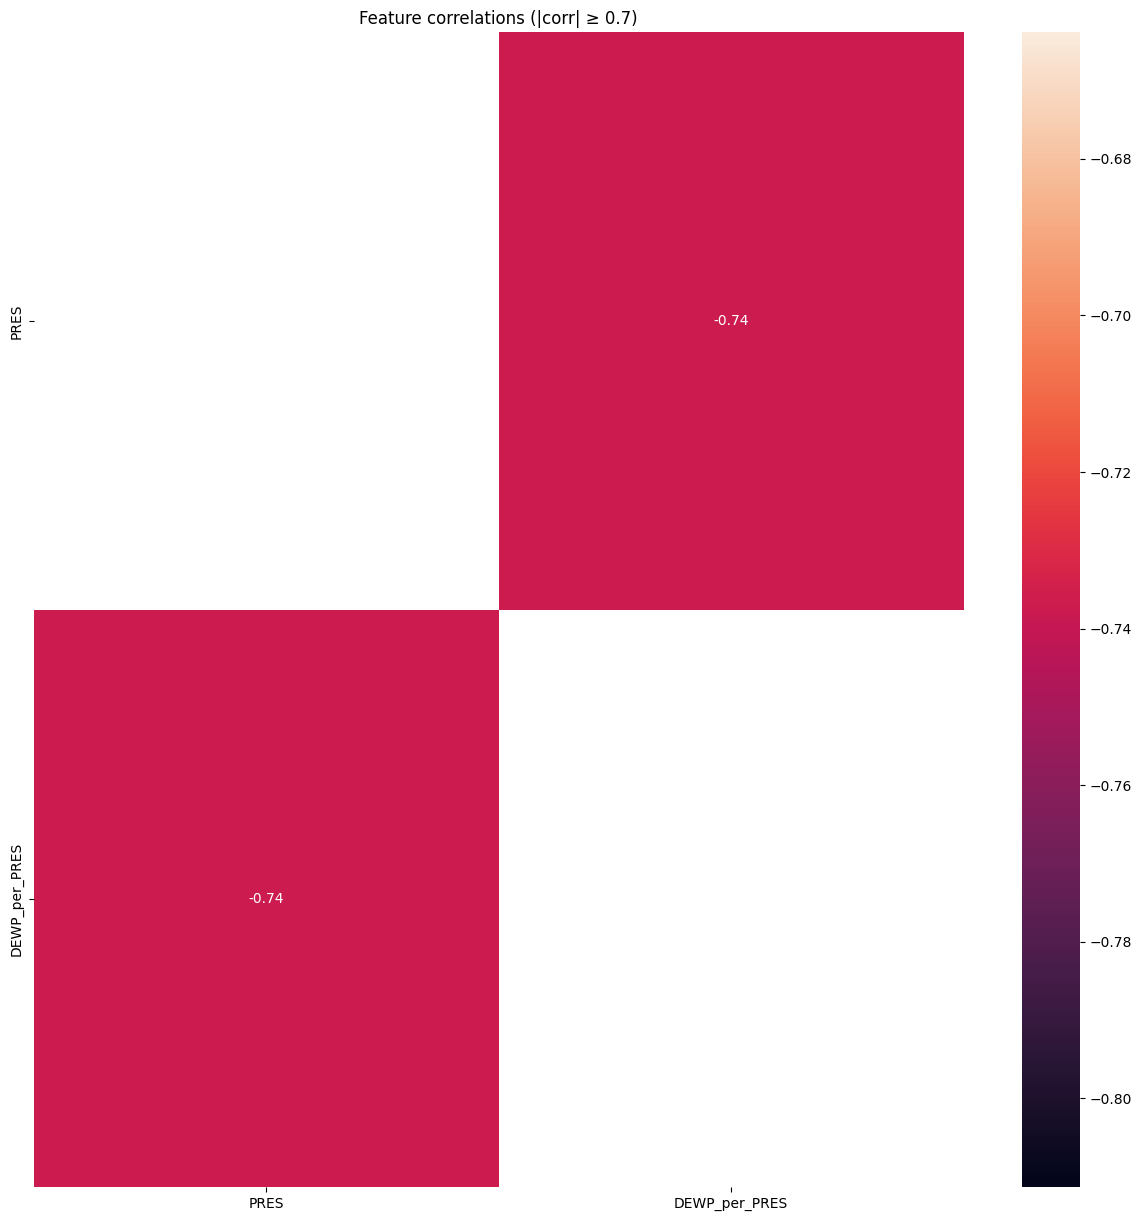

In [58]:
df_train_class = pd.concat([X_train, y_train_class], axis=1)
correlations = plot_correlations(df_train_class, df_train_class.columns.tolist(), f'Feature correlations', 0.7)

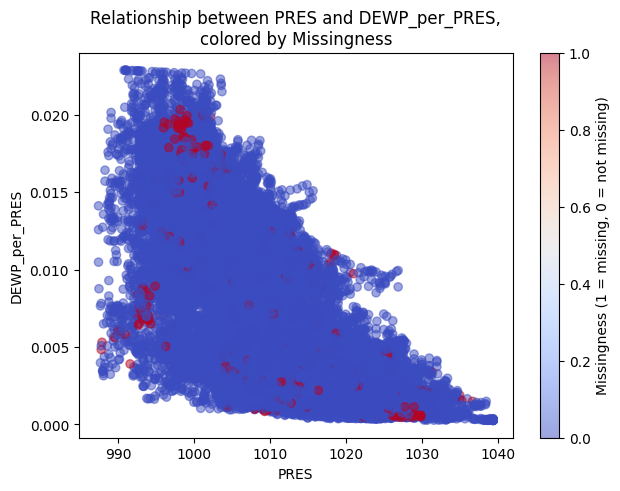

In [59]:
plot_scatter_relationship_colored_by_missingness(X_train, 'PRES', 'DEWP_per_PRES', y_train_class)

Multicollinearity is now normal. Resolved.

#### Model selection

For best, direct and straight-forward interpretability, linear models are considered. The choice lies between those that:
- are able to work with time series + classification
- provide great interpretability reliance
- are robust to exclude or partly cover basic linear assumptions (preferably; time-wise point)
- are able to take custom weights for target
- yield meaningful, comparable metrics (understand the data)

Models that were considered:
- `GLM`: allows custom weights, but assumes **independent** observations and does **not** handle autocorrelation directly.
- `GLMM`: extends `GLM` with random effects, but time-series correlation structures are **difficult** to specify cleanly and the model becomes **computationally heavy**.
- `GAM`: can approximate time structure by including lagged predictors, but does **not** explicitly model serial correlation.
- `GEE`: directly incorporates correlation structures, providing efficient estimates and straightforward residual diagnostics. However, it does **not** support custom observation weights when using autoregressive correlation structures.

Ultimately, no model accounts for both custom weights and autocorrelation. It is known that there is no out-of-the-box python implementation for that at all. 

In [examining the `statsmodels` implementation of GEE](https://www.statsmodels.org/dev/_modules/statsmodels/genmod/cov_struct.html?utm_source=chatgpt.com), the source code contains a clear warning: “weights not implemented for autoregressive cov_struct, using unweighted covariance estimate.” This reflects that correlations cannot be combined with observation-level weights. I assume the reason is cleanliness, low demand and other implementation boundaries.

Having taken the research further into other time series projects of my colleagues, I have concluded that an approximation of simulating time-series structure is reached via lagged features. The model then is allowed to assume that observations are independent in order to use custom weights. 

This also adds a necessity to account for autocorrelation in residuals to properly model the autoregressive nature of the data. If residuals at time `t` tend to be similar to errors at `t-1`, that violates the independence assumption used for standard OLS standard errors and p-values (means the model missed some time structure (like a trend, seasonality, or lag effect)).

In [60]:
# disable scientific notation (e2, e-01 etc.)
np.set_printoptions(suppress=True, precision=6)
pd.set_option("display.float_format", "{:.6f}".format)

X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
year,28051.000000,2014.277708,0.975432,2013.000000,2013.000000,2014.000000,2015.000000,2016.000000
PM10,28051.000000,113.687908,94.611554,2.000000,41.000000,92.000000,159.000000,654.582000
SO2,28051.000000,19.025173,23.821504,0.285600,4.000000,10.000000,23.000000,169.000000
NO2,28051.000000,60.210110,36.111171,2.000000,33.000000,55.000000,81.252050,220.355000
CO,28051.000000,1233.970910,1144.794770,100.000000,500.000000,900.000000,1500.000000,9000.000000
O3,28051.000000,54.157375,54.694304,0.214200,9.000000,41.000000,78.000000,311.466000
PRES,28051.000000,1011.533719,10.279169,987.441440,1003.200000,1011.100000,1019.700000,1039.400000
RAIN,28051.000000,0.050886,0.506561,0.000000,0.000000,0.000000,0.000000,10.700000
WSPM,28051.000000,1.710494,1.234800,0.000000,0.900000,1.400000,2.300000,8.858560
hour_sin,28051.000000,0.000118,0.707119,-1.000000,-0.707107,0.000000,0.707107,1.000000


In [61]:
# Standardization: for most intuitive interpretation, stable magnitudes and valid comparisons
to_standardize = ['year', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'PRES', 'RAIN', 'WSPM', 'TEMP_residual', 'DEWP_per_PRES']

scaler = StandardScaler().fit(X_train[to_standardize])
scaler_df = pd.DataFrame({'col': to_standardize, 'std': scaler.scale_})
scaler_df.to_csv("std_scaler_stds.csv", index=False)

X_train[to_standardize] = pd.DataFrame(scaler.transform(X_train[to_standardize]), columns=to_standardize, index=X_train.index)
X_test[to_standardize] = pd.DataFrame(scaler.transform(X_test[to_standardize]), columns=to_standardize, index=X_test.index)

In [62]:
X_train.head()

,year,PM10,SO2,NO2,CO,O3,PRES,RAIN,WSPM,hour_sin,...,wd_binned_S,wd_binned_SE,wd_binned_SW,wd_binned_W,season,is_weekend,TEMP_residual,month_cos_residual,working_hour_component,DEWP_per_PRES
datetime,,,,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,-1.309914,-1.159371,-0.630751,-1.473535,-0.815856,0.417649,1.115507,-0.100455,2.178129,0.000000,...,0.000000,0.000000,0.000000,0.000000,2,0,0.051350,-0.730689,0.000000,-1.074056
2013-03-01 01:00:00,-1.309914,-1.117092,-0.630751,-1.473535,-0.815856,0.417649,1.134964,-0.100455,2.421088,0.258819,...,0.000000,0.000000,0.000000,0.000000,2,0,-0.071656,-0.709743,0.000000,-1.065886
2013-03-01 02:00:00,-1.309914,-1.127662,-0.588772,-1.390456,-0.815856,0.344514,1.164150,-0.100455,3.149964,0.500000,...,0.000000,0.000000,0.000000,0.000000,2,0,-0.071656,-0.709743,0.000000,-1.065934
2013-03-01 03:00:00,-1.309914,-1.138231,-0.336894,-1.362764,-0.815856,0.326230,1.261436,-0.100455,1.125308,0.707107,...,0.000000,0.000000,0.000000,0.000000,2,0,0.005332,-0.751634,0.000000,-1.082109
2013-03-01 04:00:00,-1.309914,-1.169940,-0.294914,-1.335071,-0.815856,0.326230,1.329536,-0.100455,0.234460,0.866025,...,0.000000,0.000000,0.000000,0.000000,2,0,-0.076606,-0.755125,0.000000,-1.083479


Initial baseline fit:

In [63]:
X = sm.add_constant(X_train)  # predictors
cov_struct = Independence() # assume observations are independent

# For one station (treating all rows as one group)
groups = np.ones(len(y_train_class))

model = sm.GEE(
    endog=y_train_class,
    exog=X,
    groups=groups,
    family=sm.families.Binomial(),
    cov_struct=cov_struct,
    weights=weights  # observation-level weights
)

res = model.fit(start_params=None, maxiter=2000)

#### Independent residuals (no autocorrelation in residuals)

As mentioned above, we are going to model the autocorrelation structure via adding lagged (or other smoothing/rolling) features. For it, we rely on the `Ljung-Box test`. It uses a Q-statistic to test the null hypothesis that all autocorrelations up to lag `k` are zero.

In [64]:
pearson_resid = res.resid_pearson
print(acorr_ljungbox(pearson_resid, lags=[12,24], return_df=False))

         lb_stat  lb_pvalue
12 115567.583811   0.000000
24 183536.713725   0.000000


The `p-value` is scaled by number of observations, so it cannot be the only reliable tool in determining autocorrelation structure. If `p-value` is indeed `< 0.5`, the null-hypothesis is rejected and autocorrelation in residuals is present (we have to model it). And if it is present, we would have to plot `ACF/PACF` to get the proper lag order in any case. The plots are also going to confirm the hypothesis once again.

But in order to plot autocorrelation functions, we need to select the most sensible features to engineer (numerical continuous that don't depend on the calender). We pick the highest correlated with the target linearly pair-wise (`Pearson`), consider `VIF` and domain knowledge.

By "sensible" features, we imply that they (a) actually have temporal persistence (pollutants, TEMP, dew point, wind speed), and/or (b) are domain-plausible predictors of the target. This keeps the model compact and the lags useful.

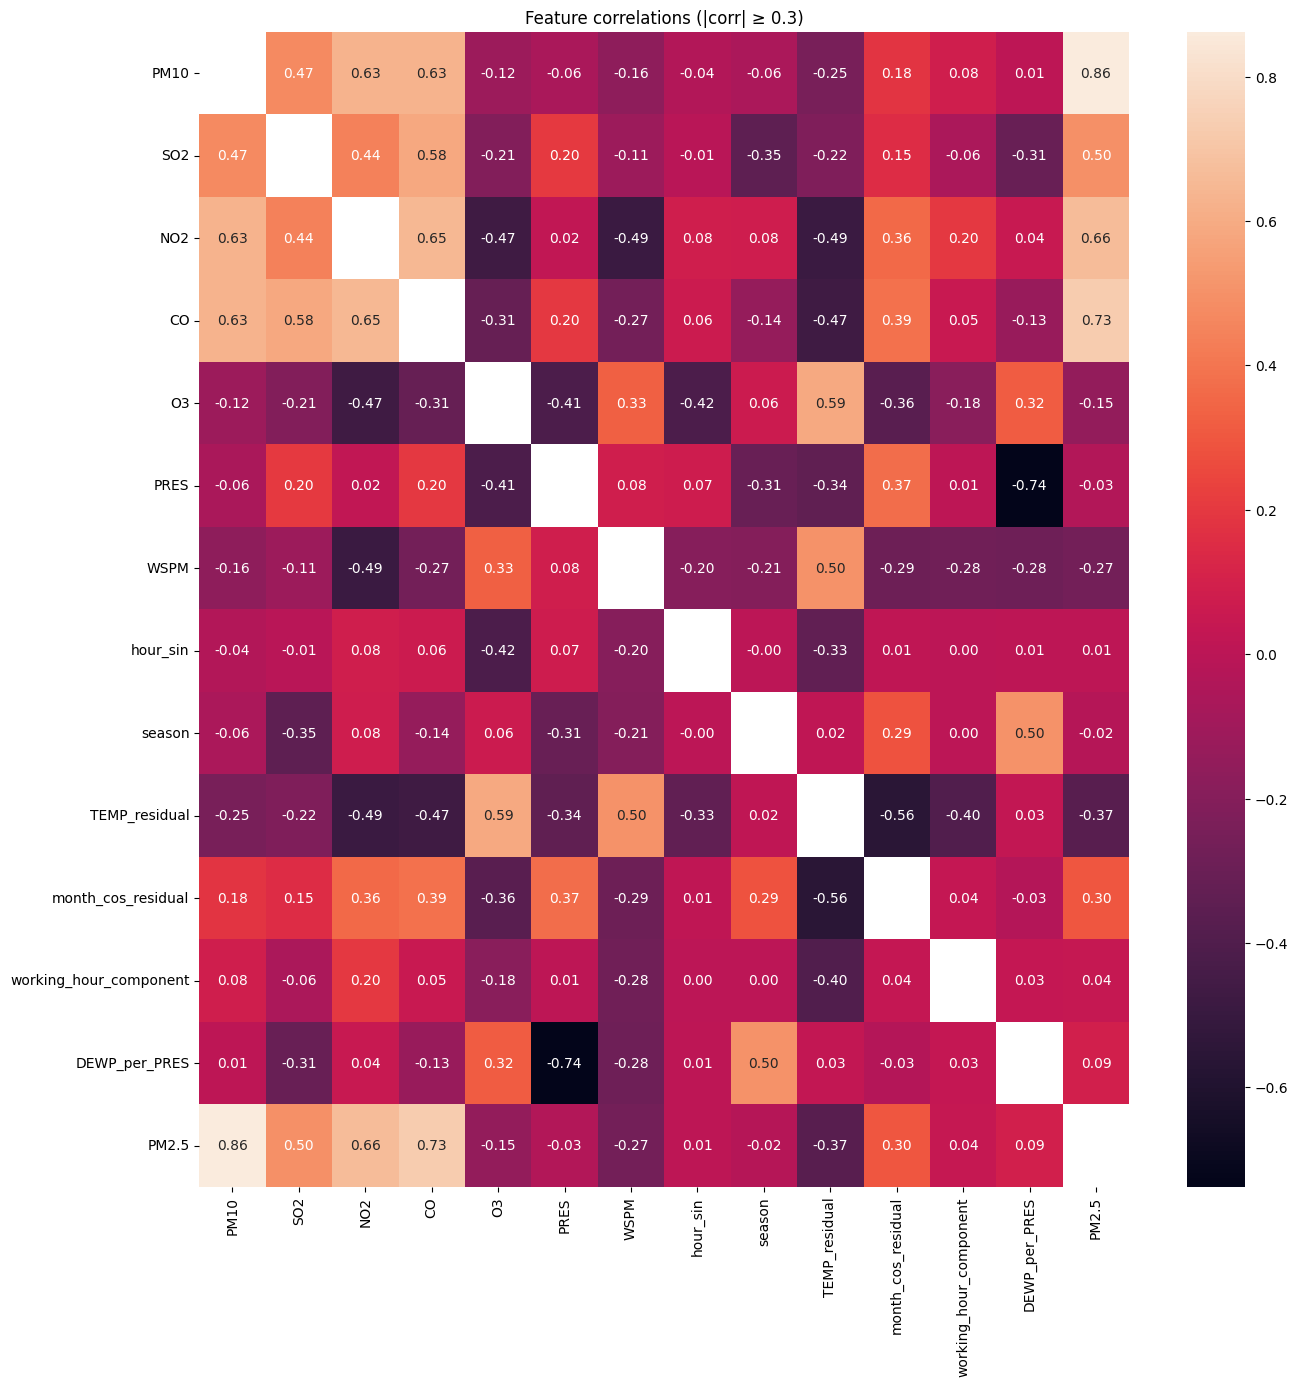

,abs_corr,has_nulls
PM10,0.862125,False
CO,0.728662,False
NO2,0.663428,False
SO2,0.496082,False
TEMP_residual,0.372873,False
month_cos_residual,0.299726,False
WSPM,0.266702,False
wd_binned_N,0.149068,False
O3,0.148318,False
wd_binned_NW,0.122190,False


In [79]:
df_train = pd.concat([X_train, y_train.fillna(value=y_train.median())], axis=1)
correlations = plot_correlations(df_train, df_train.columns.tolist(), f'Feature correlations', 0.3)

get_corr_null_info_for_a_feat(df_train, TARGET, correlations, df_train.columns.tolist())

In [80]:
perform_VIF(X_train, list(X_train.columns), CLASS_TARGET).head()

,feature,VIF
26,DEWP_per_PRES,3.843800
7,PRES,3.733284
23,TEMP_residual,3.678316
4,NO2,3.379495
5,CO,2.923003


Based on the observed features, domain logic cannot deny their relevance. The unique set of features to engineer:

In [88]:
set([CLASS_TARGET, 'DEWP_per_PRES', 'PRES', 'SO2', 'CO', 'NO2', 'WSPM', 'PM10', 'O3'])

{'CO',
 'DEWP_per_PRES',
 'NO2',
 'O3',
 'PM10',
 'PM2.5_miss',
 'PRES',
 'SO2',
 'WSPM'}

The final set of only continuous variables (no categories and cyclical features - they don’t depend on past values of the series, but only on the clock/calendar): `PM2.5_miss`, `CO`, `DEWP_per_PRES`, `PRES`, `NO2`, `O3`, `PM10`, `SO2`, `WSPM`.

In [65]:
sensible_features = [CLASS_TARGET, 'CO', 'DEWP_per_PRES', 'NO2', 'O3', 'PM10', 'PRES', 'SO2', 'WSPM']

##### Stationarity check

If a predictor is strongly stationary (its central tendencies are constant) **and** uncorrelated across lags (flat `ACF`), then lagged versions of it may simply reflect nothing new. Performing this check, we are potentially reducing the list of sensible features for more efficient computation. In case of non-stationarity, we are going to consider differencing them before adding lags.

We are testing stationarity with `Augmented Dickey–Fuller test` (`ADF`). The test's null hypothesis checks whether a unit root is present (the series is non-stationary), while the alternative hypothesis is that the series is stationary (or trend-stationary).

In [90]:
for feat in sensible_features:
    print(f"Is {feat} stationary? {check_stationarity_adf(df_train_class[feat], verbose=False)['is_stationary']}")

Is PM2.5_miss stationary? True
Is CO stationary? True
Is DEWP_per_PRES stationary? True
Is NO2 stationary? True
Is O3 stationary? True
Is PM10 stationary? True
Is PRES stationary? True
Is SO2 stationary? True
Is WSPM stationary? True


#### ACF/PACF analysis

Now that we know the set of sensible features is meaningful for the model, we may perform `ACF`/`PACF` analysis to understand and model the autocorrelation residual deficiency.

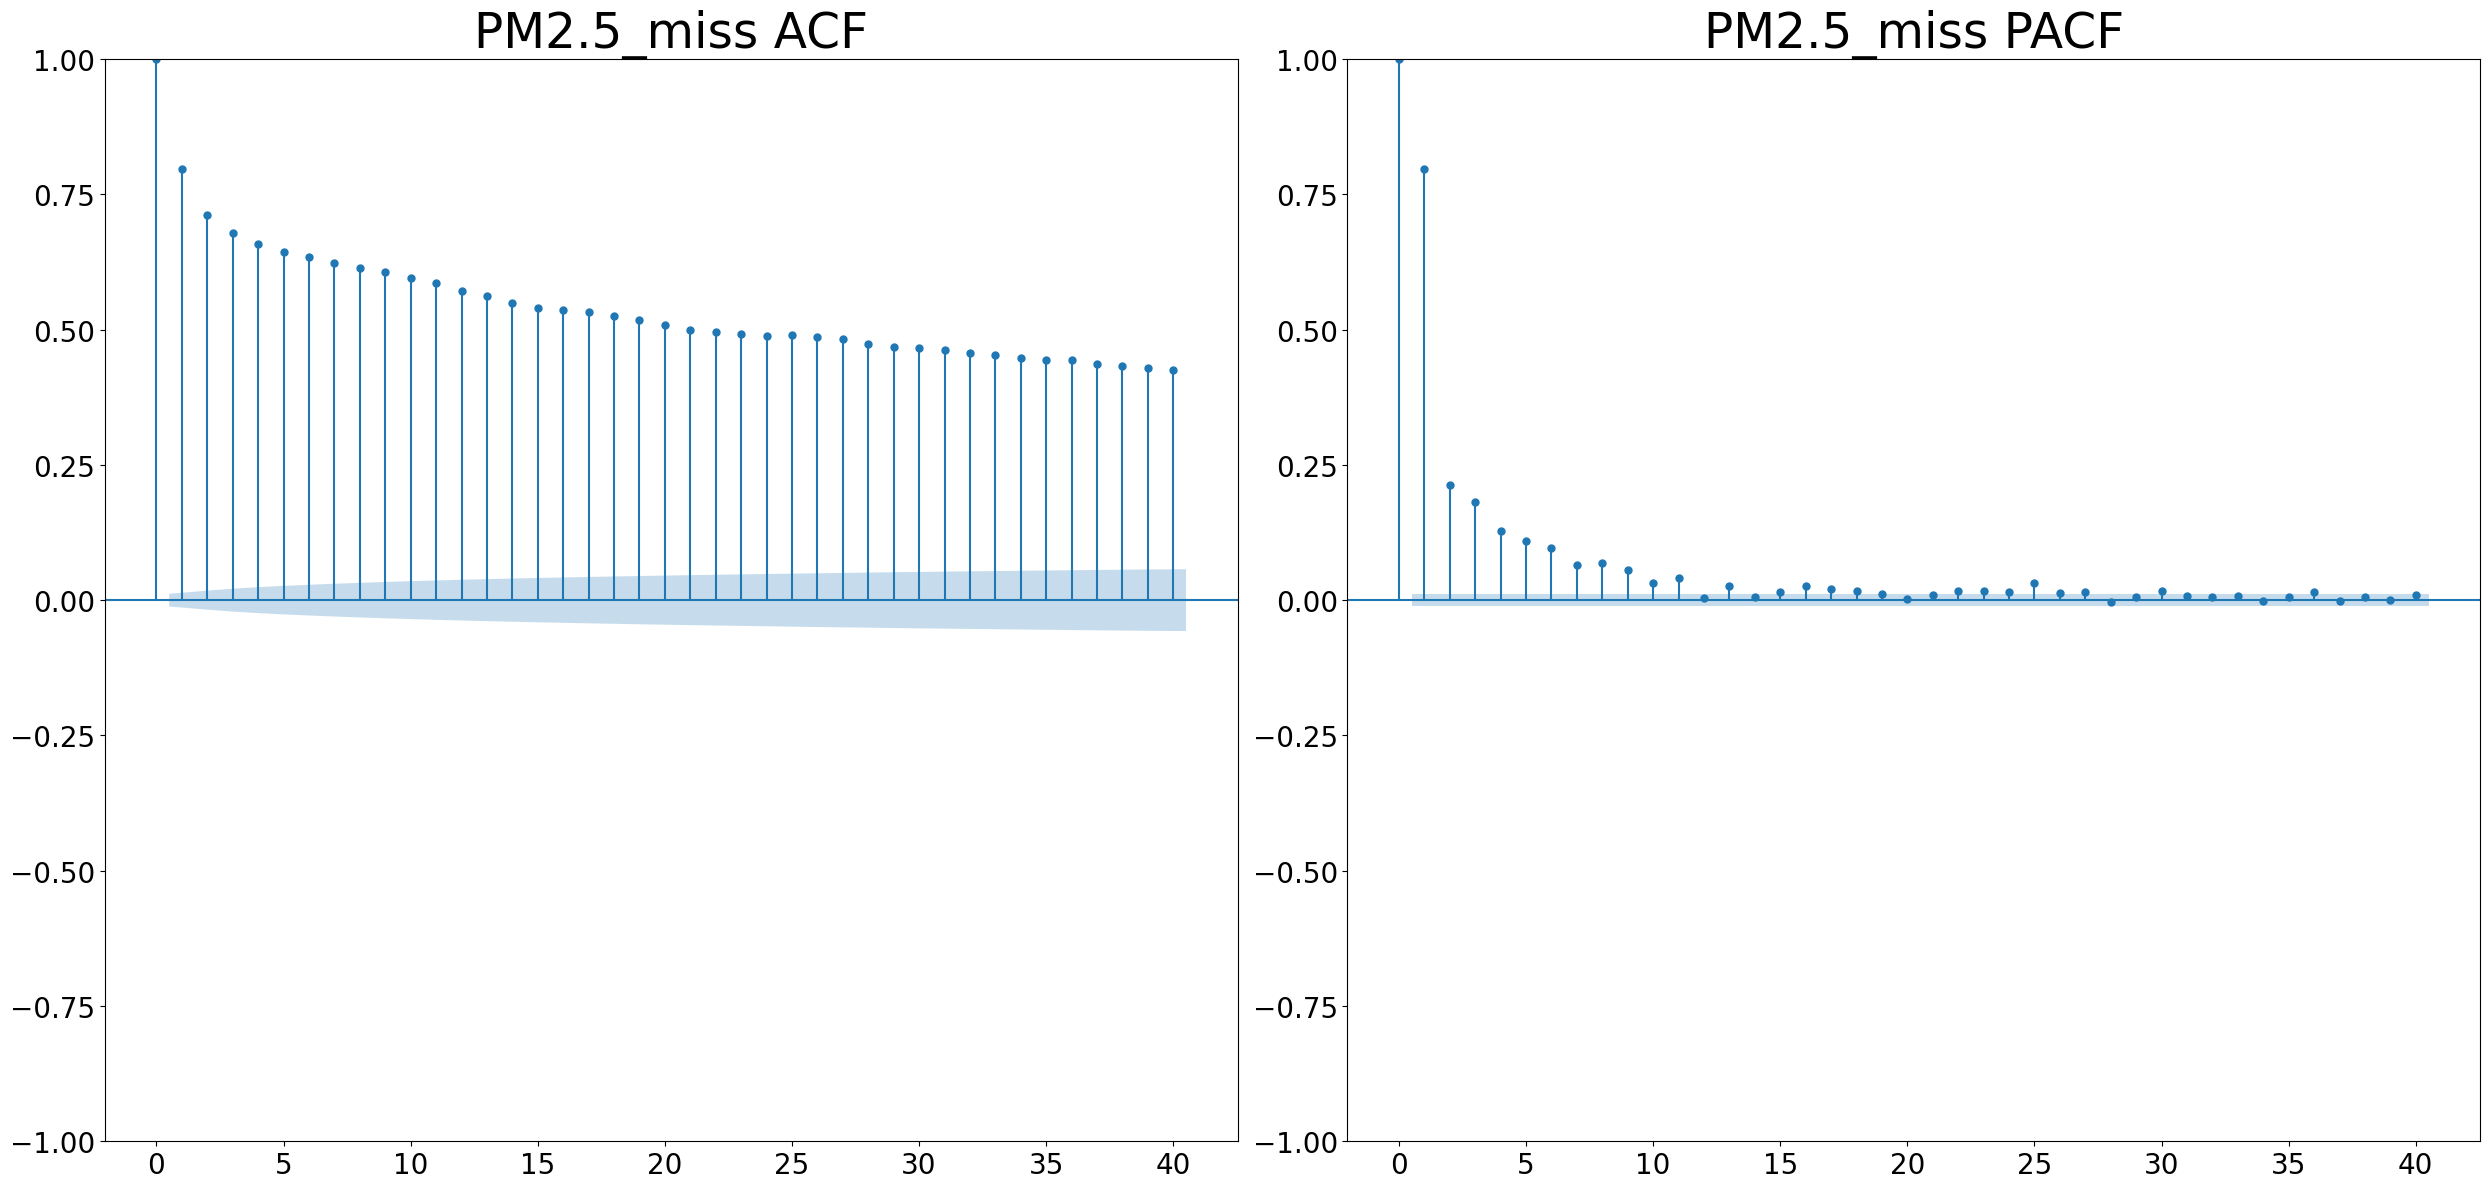

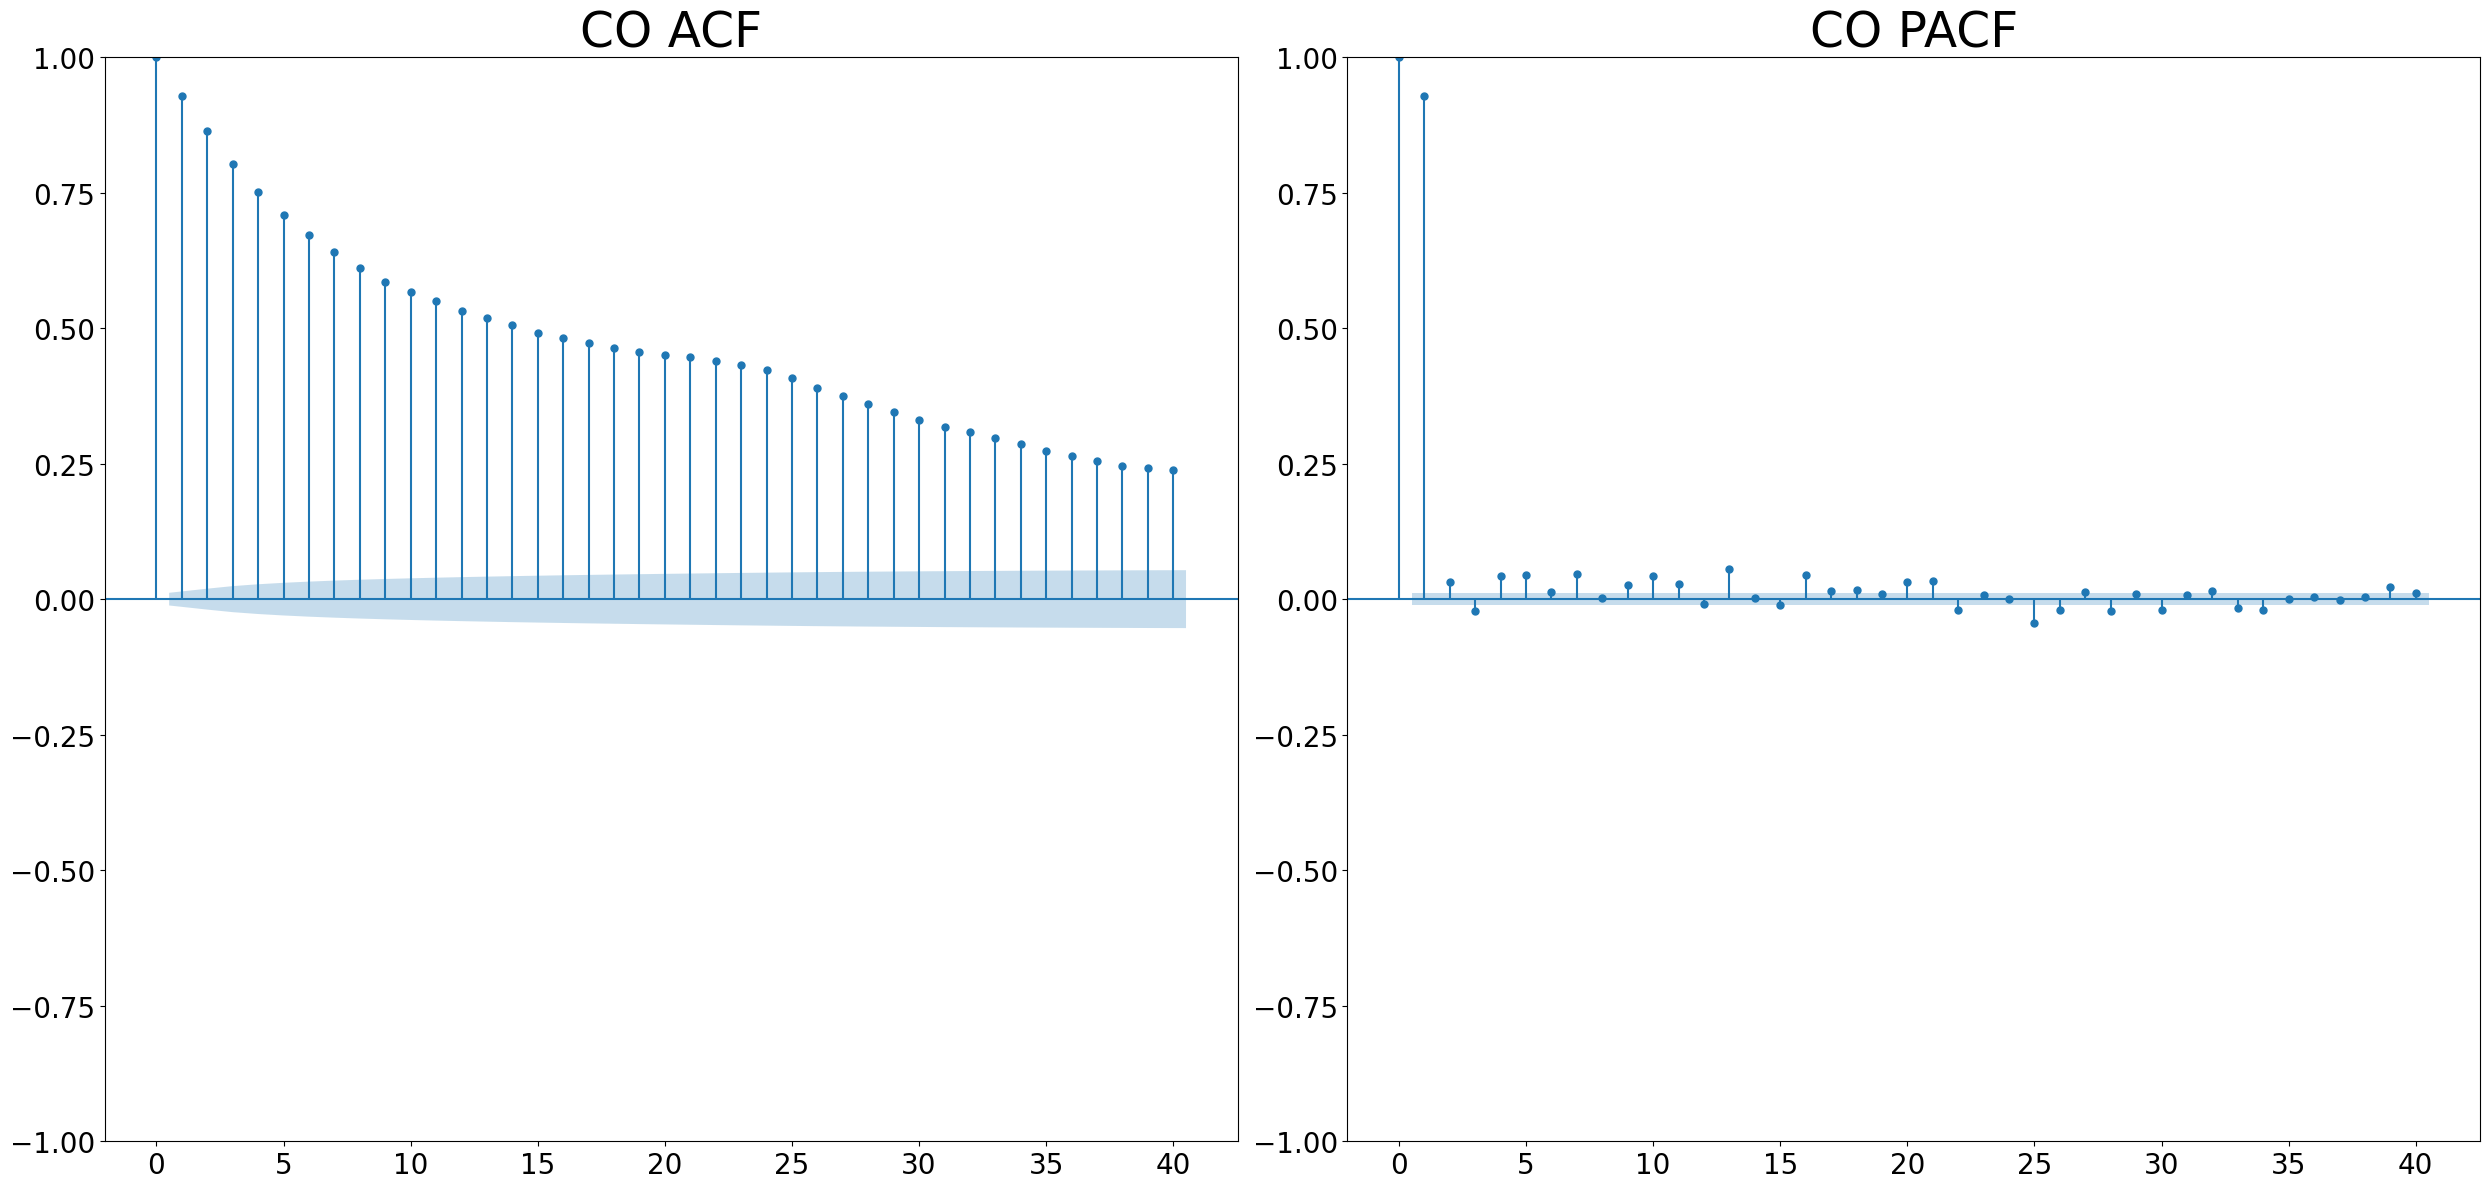

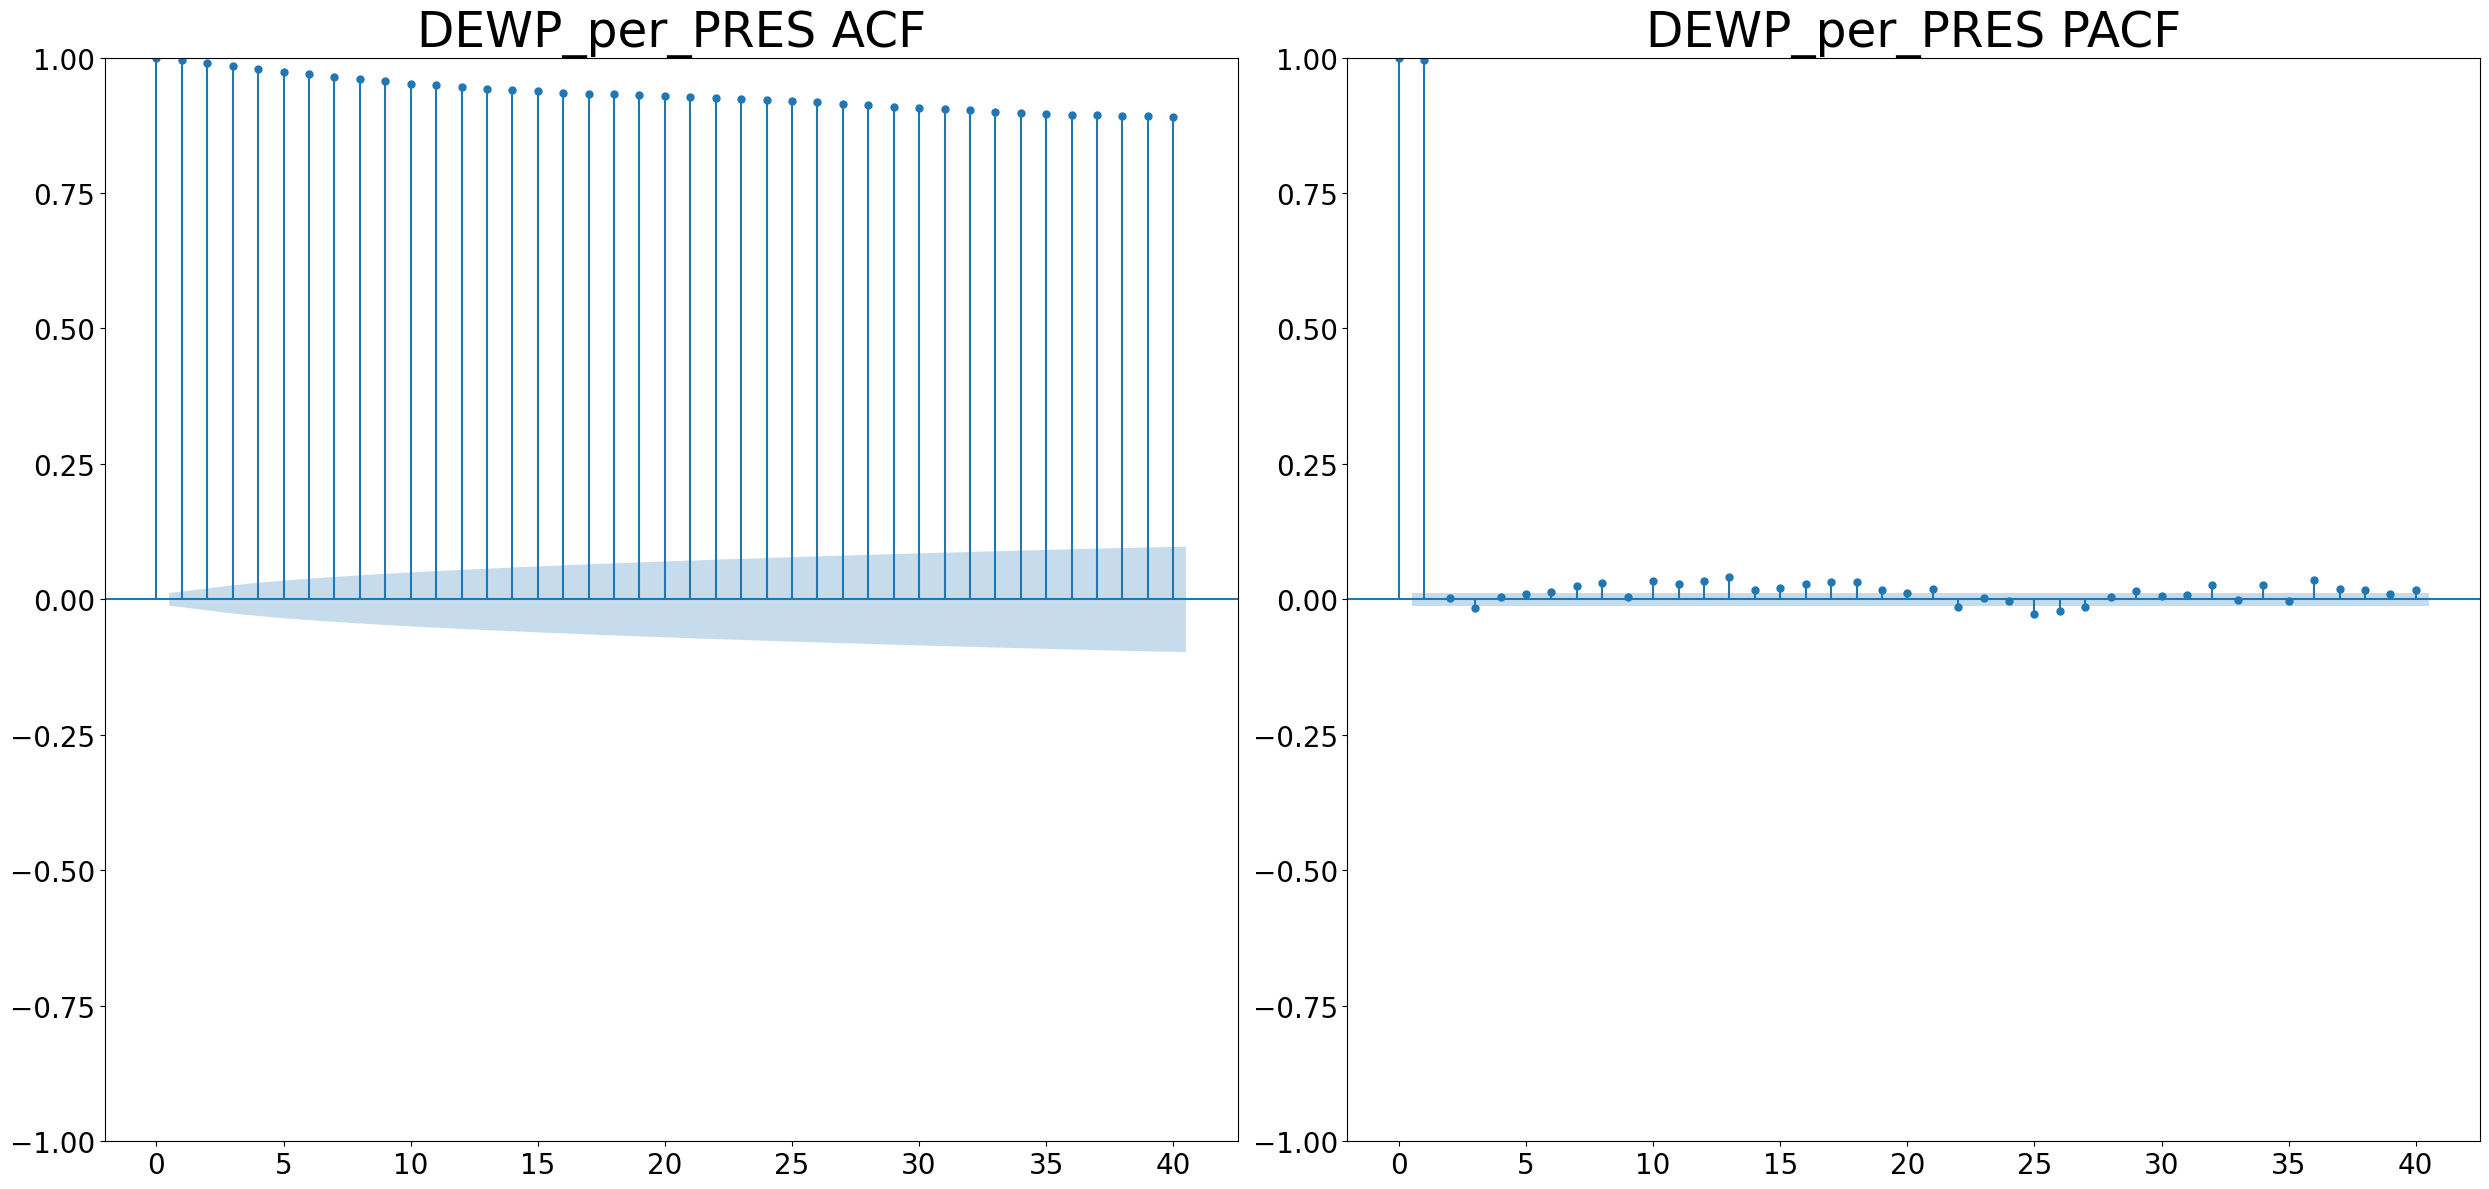

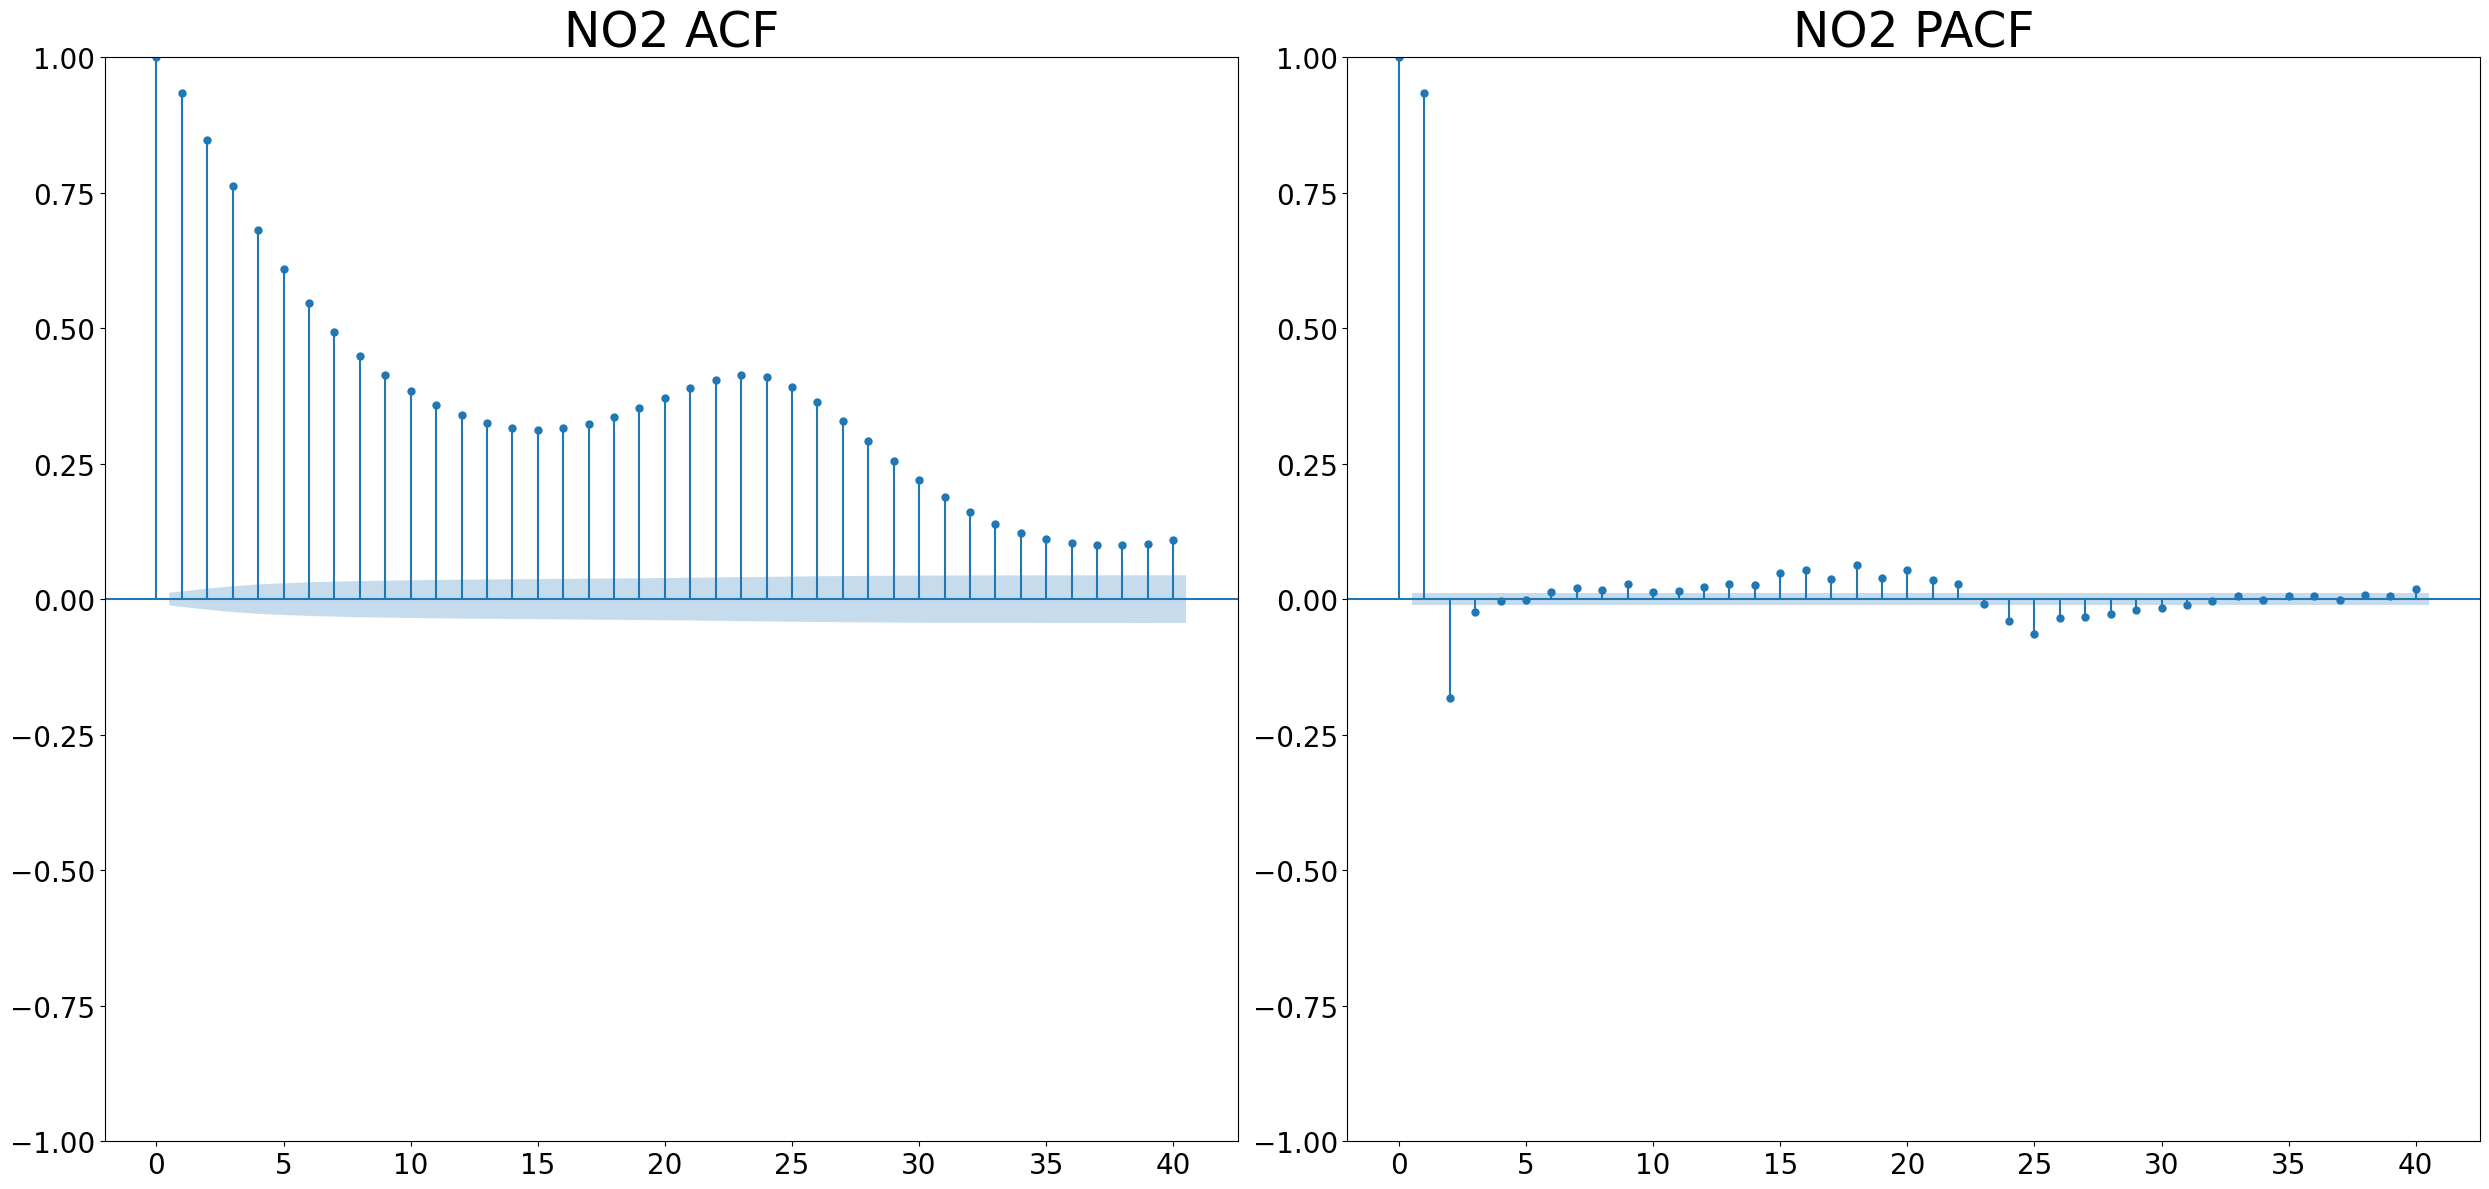

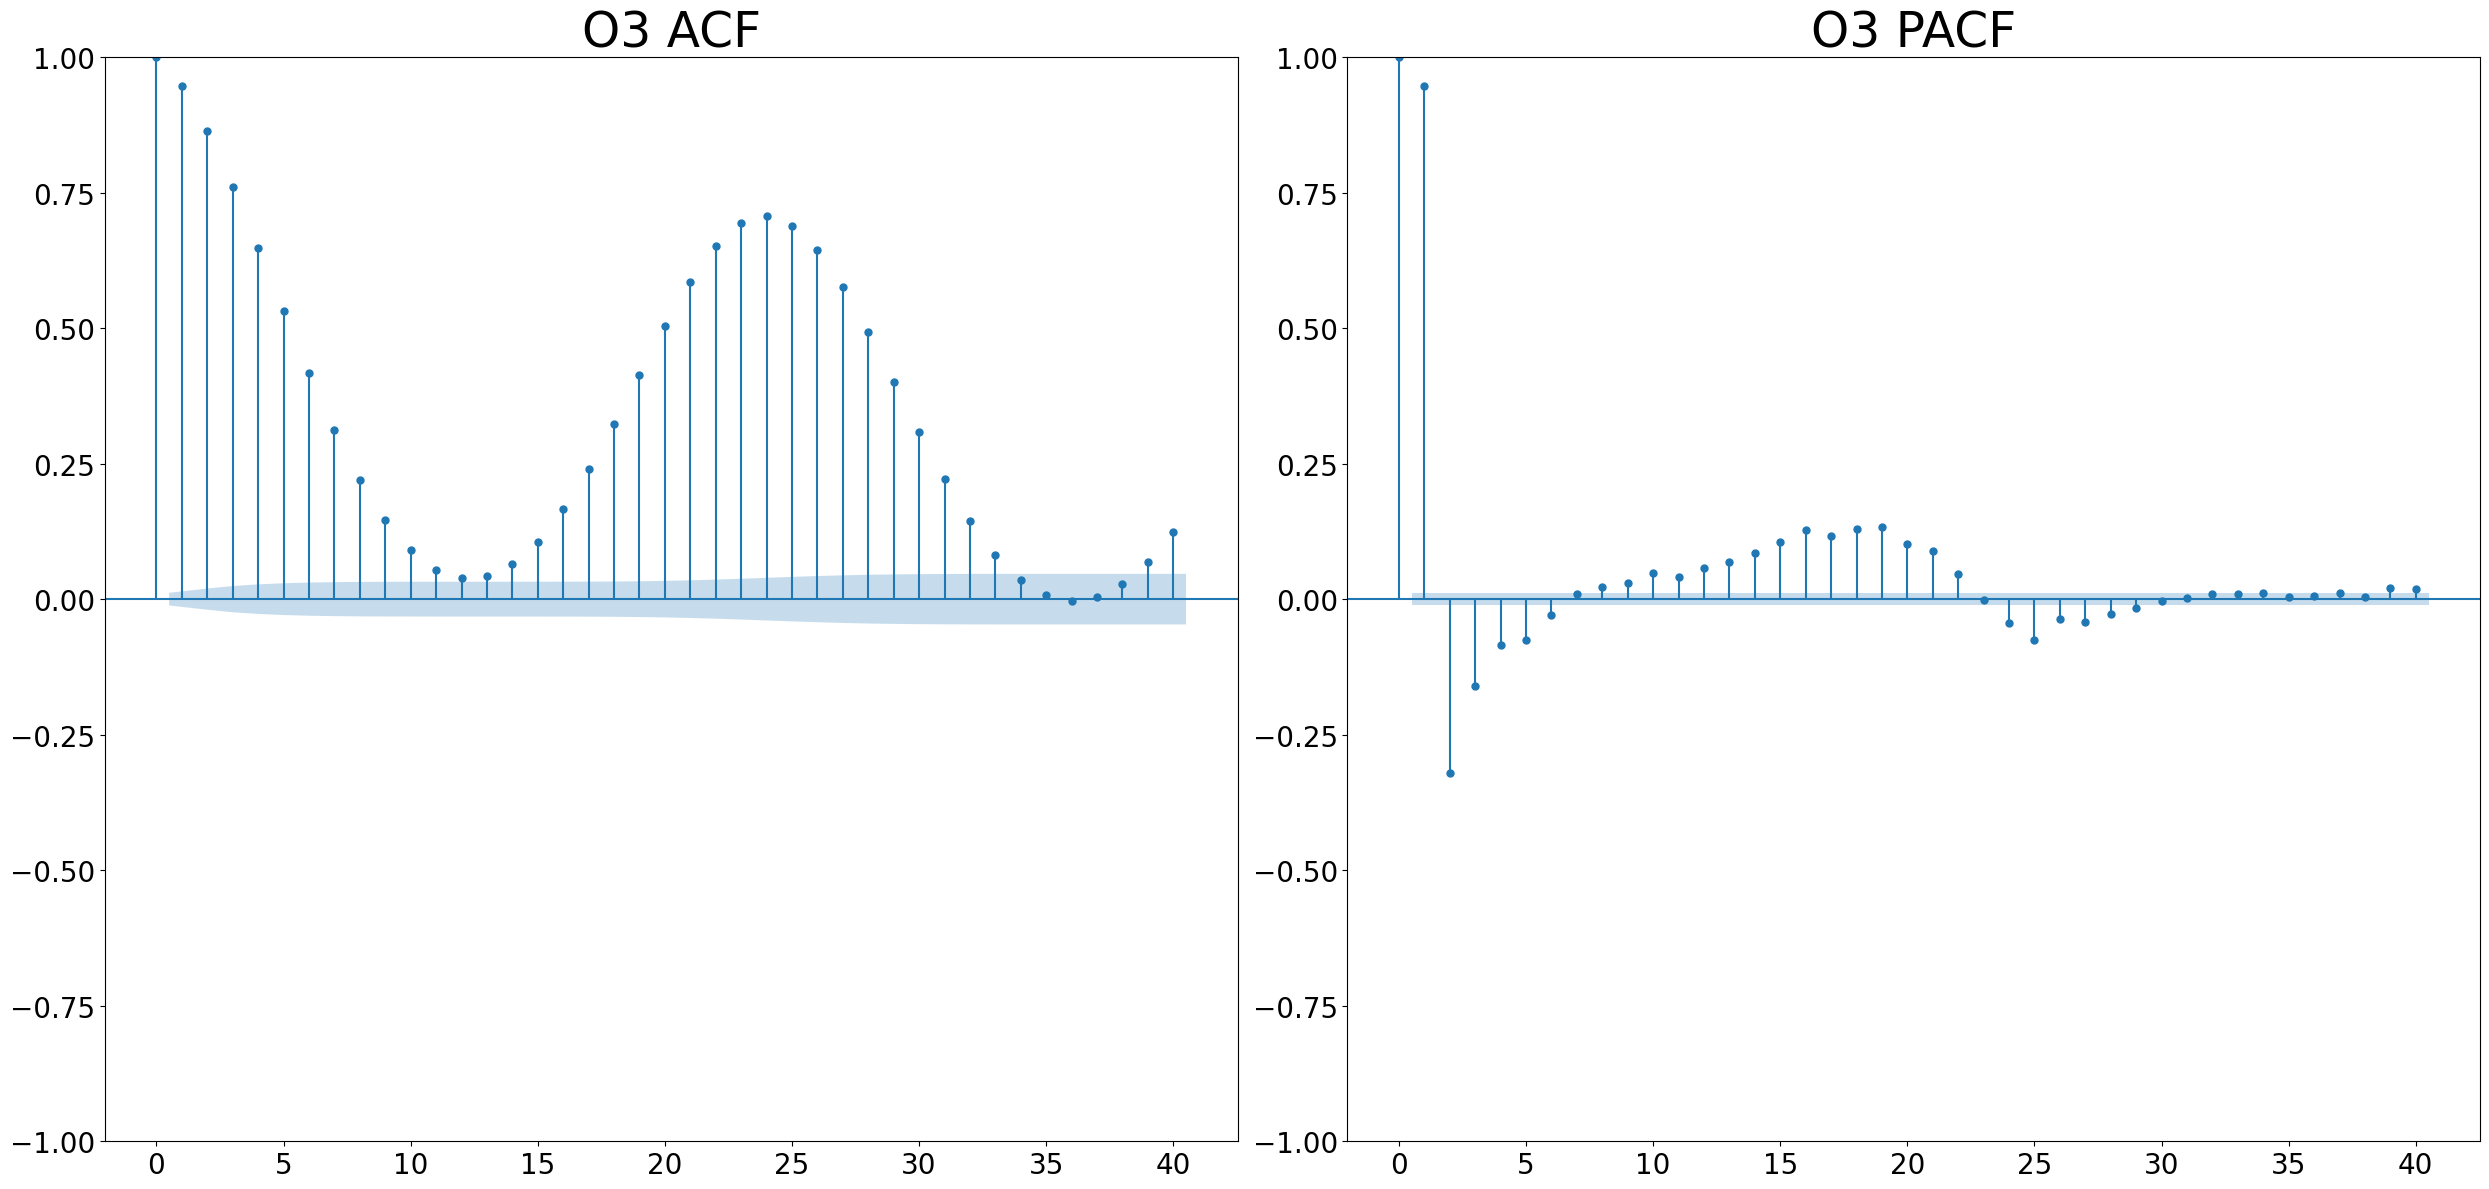

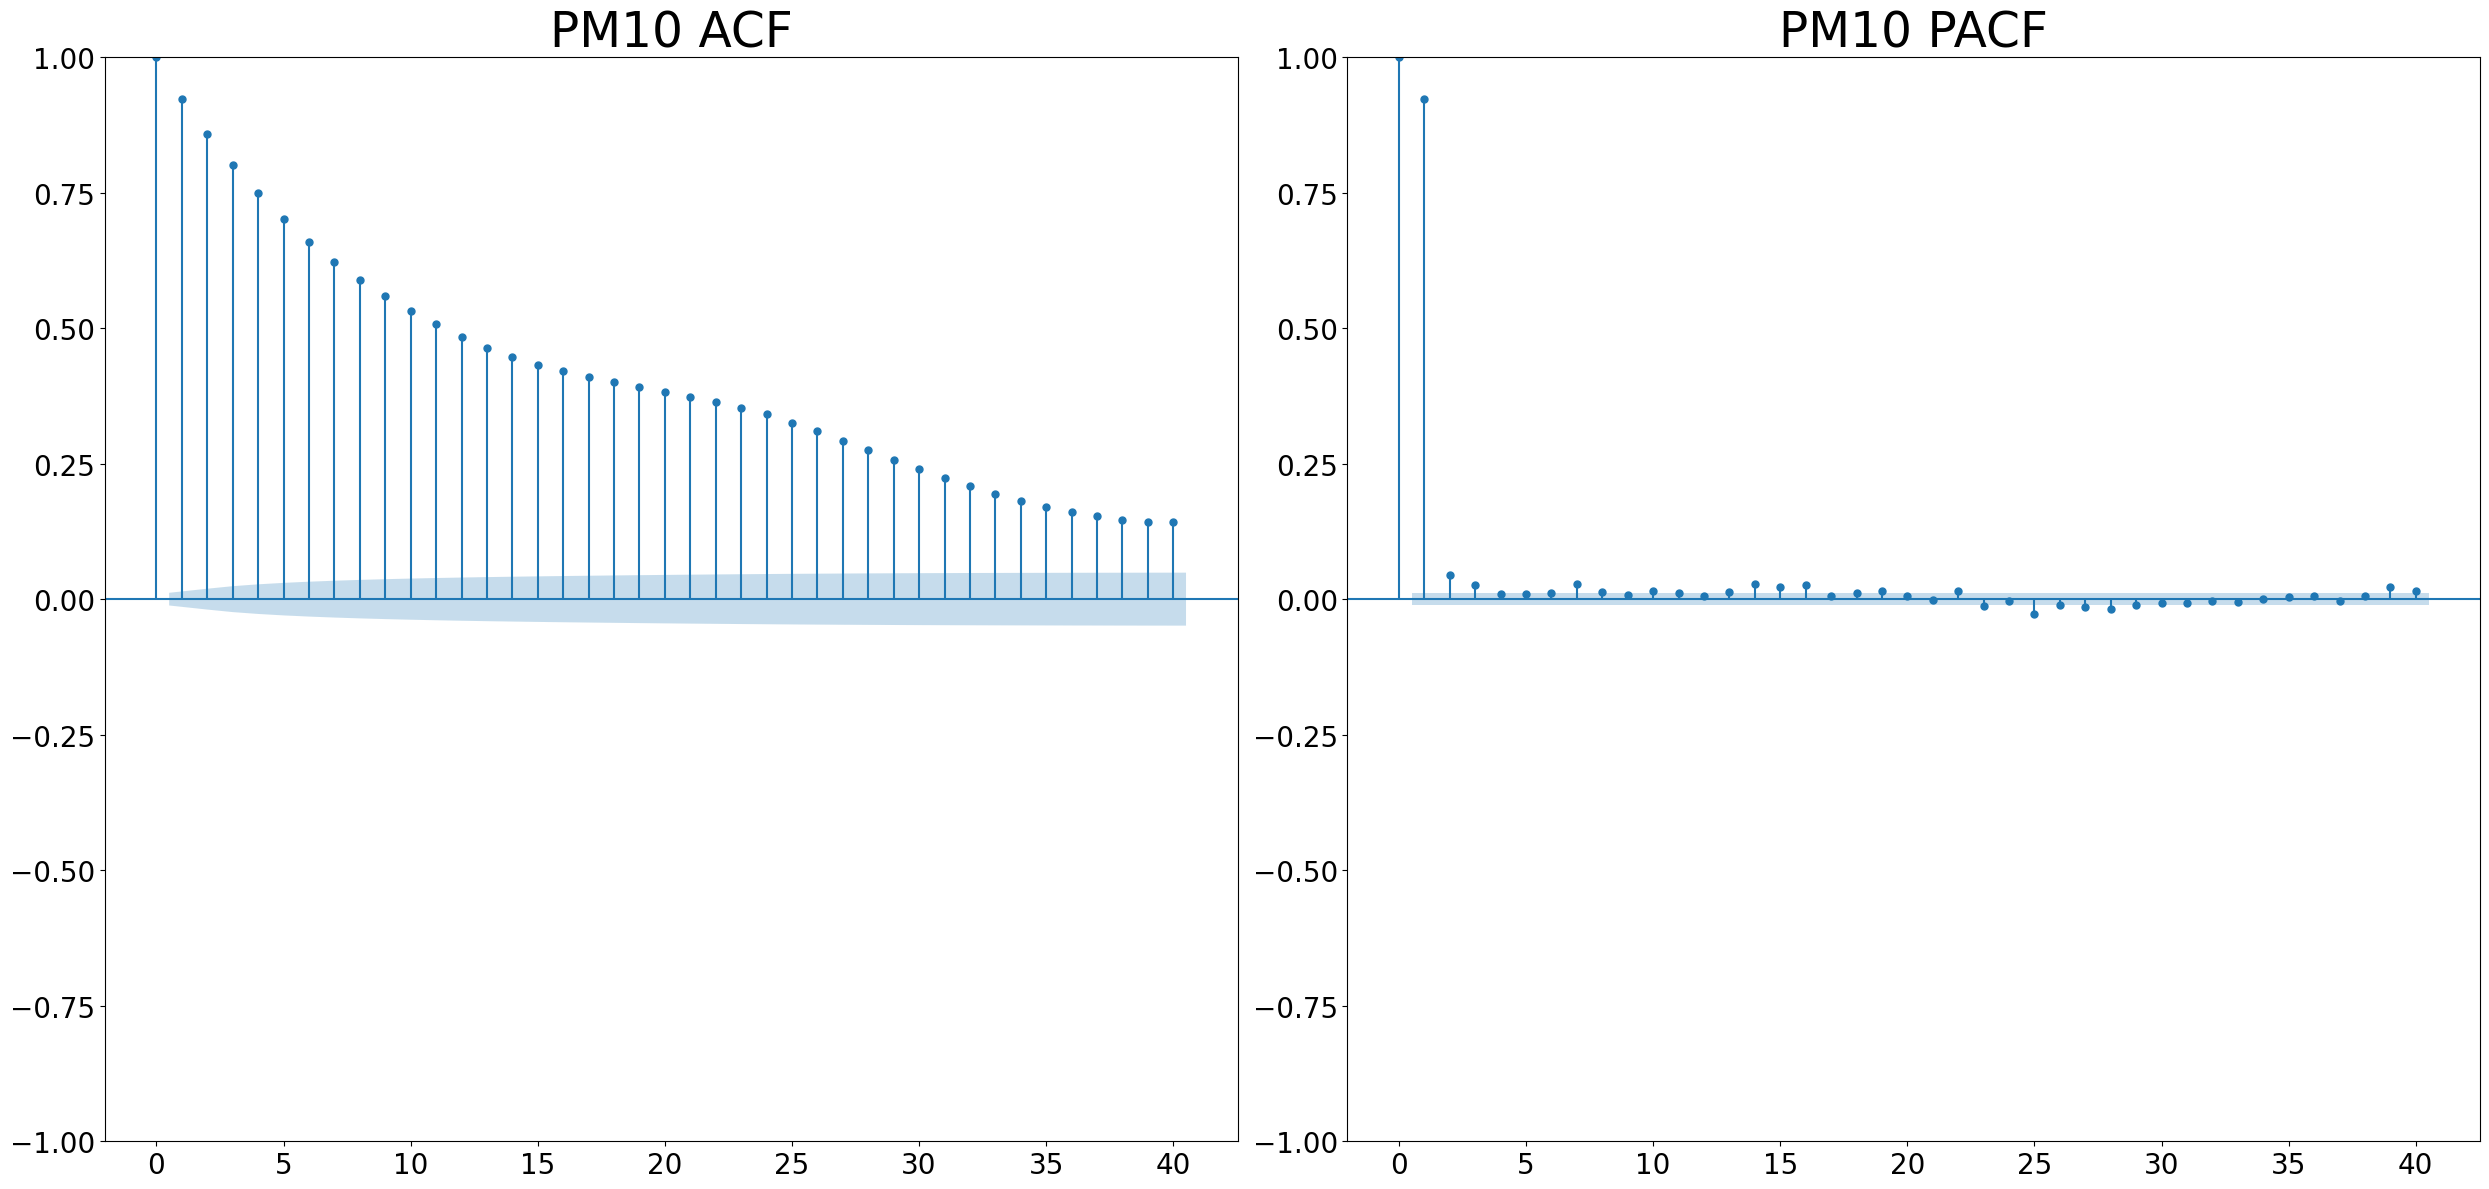

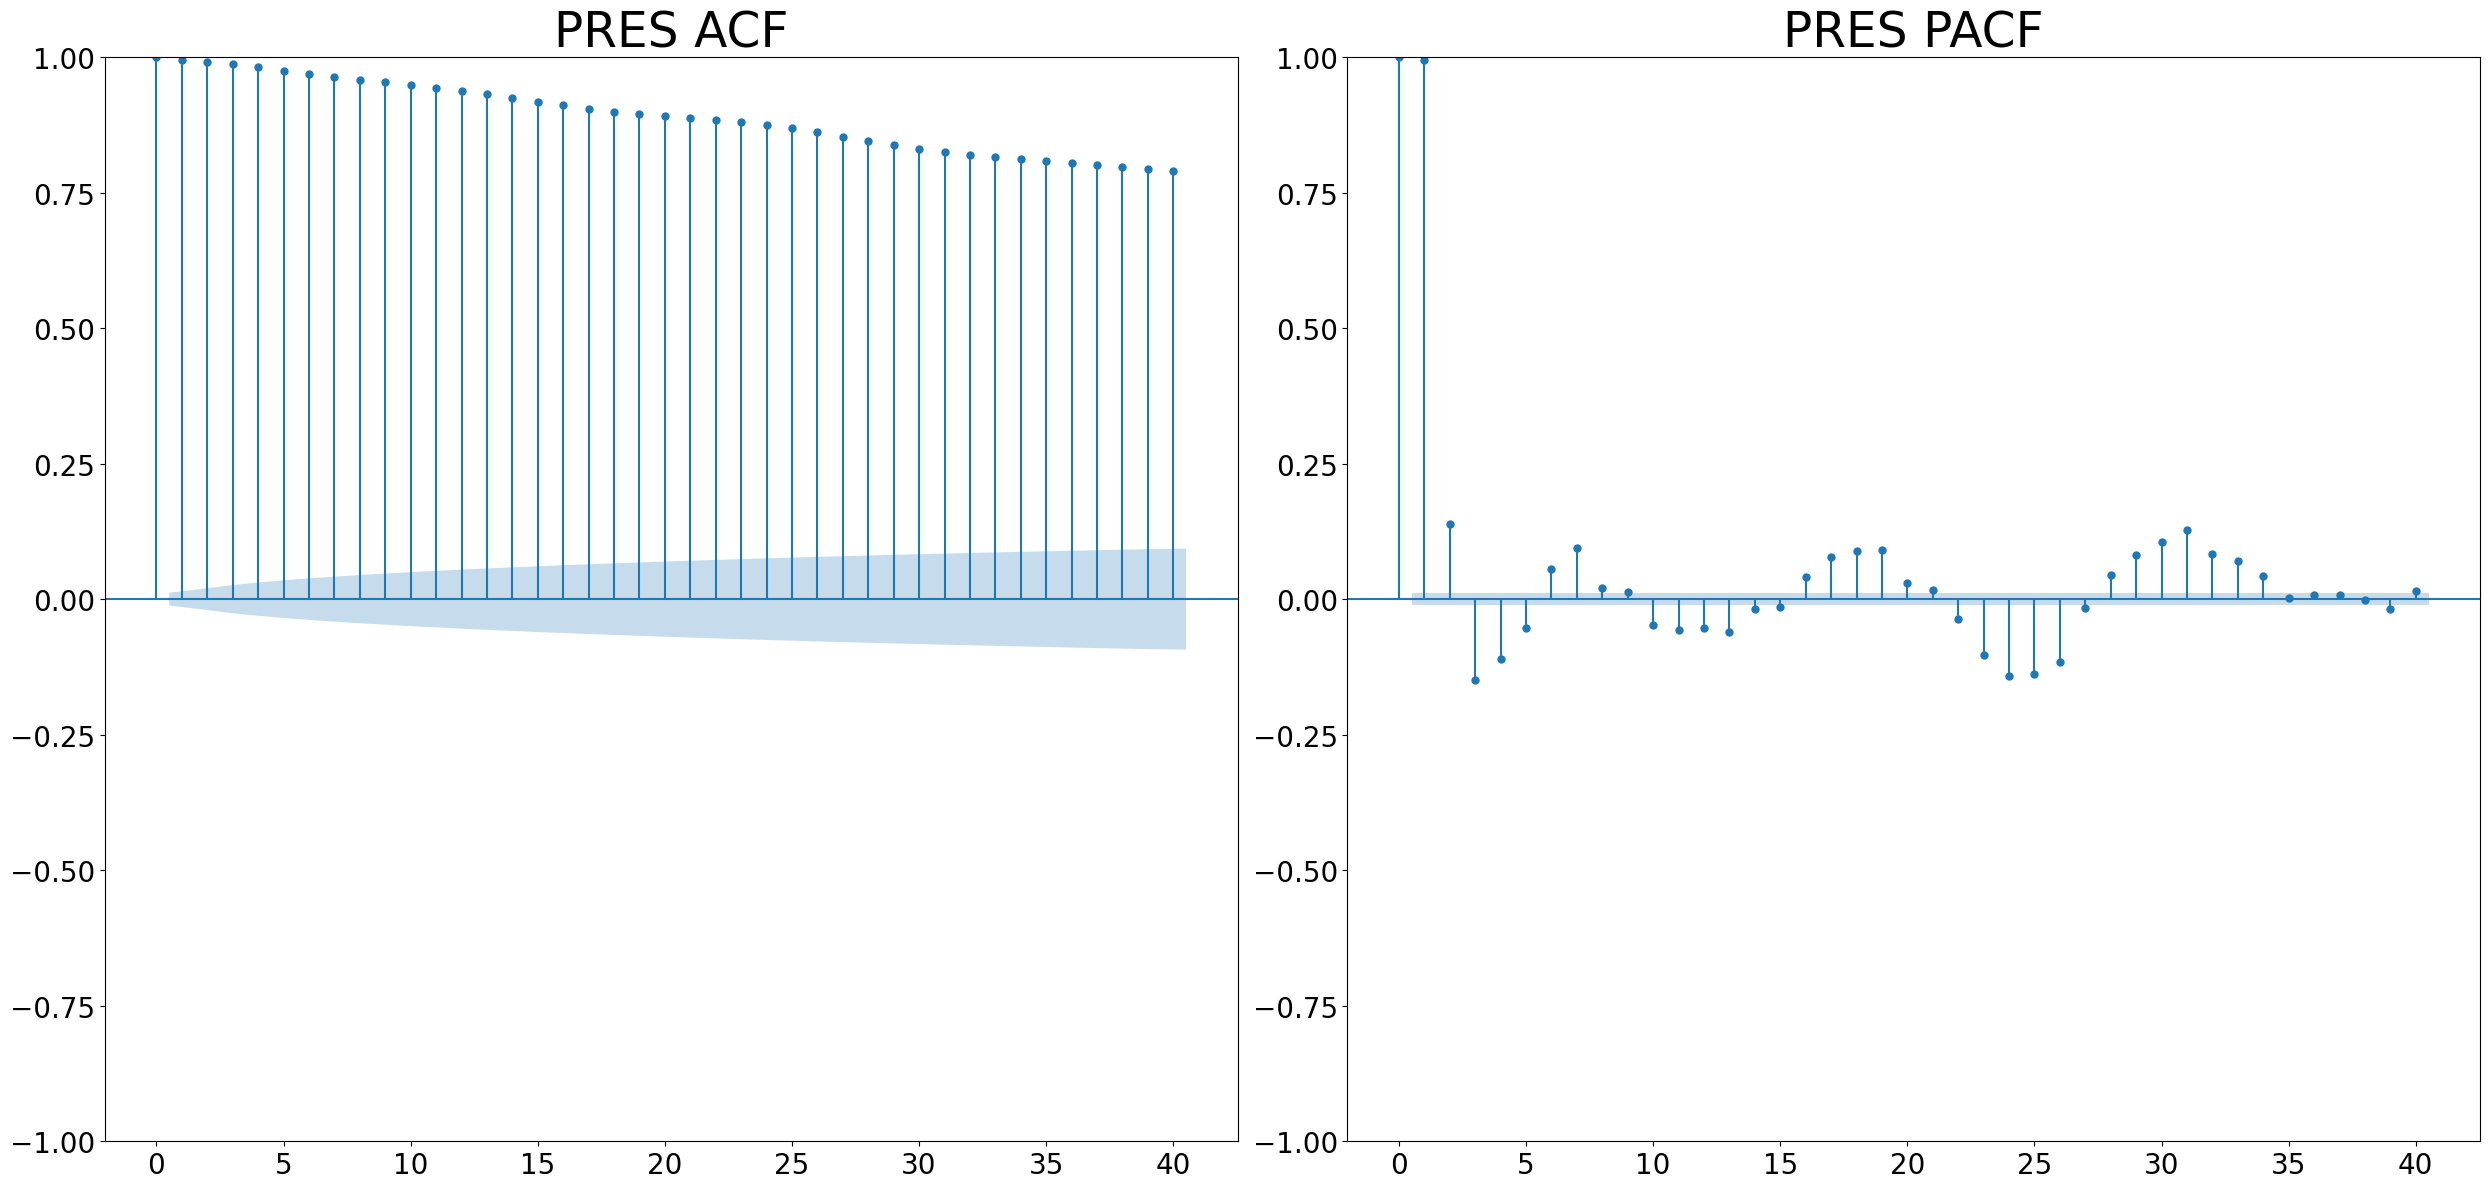

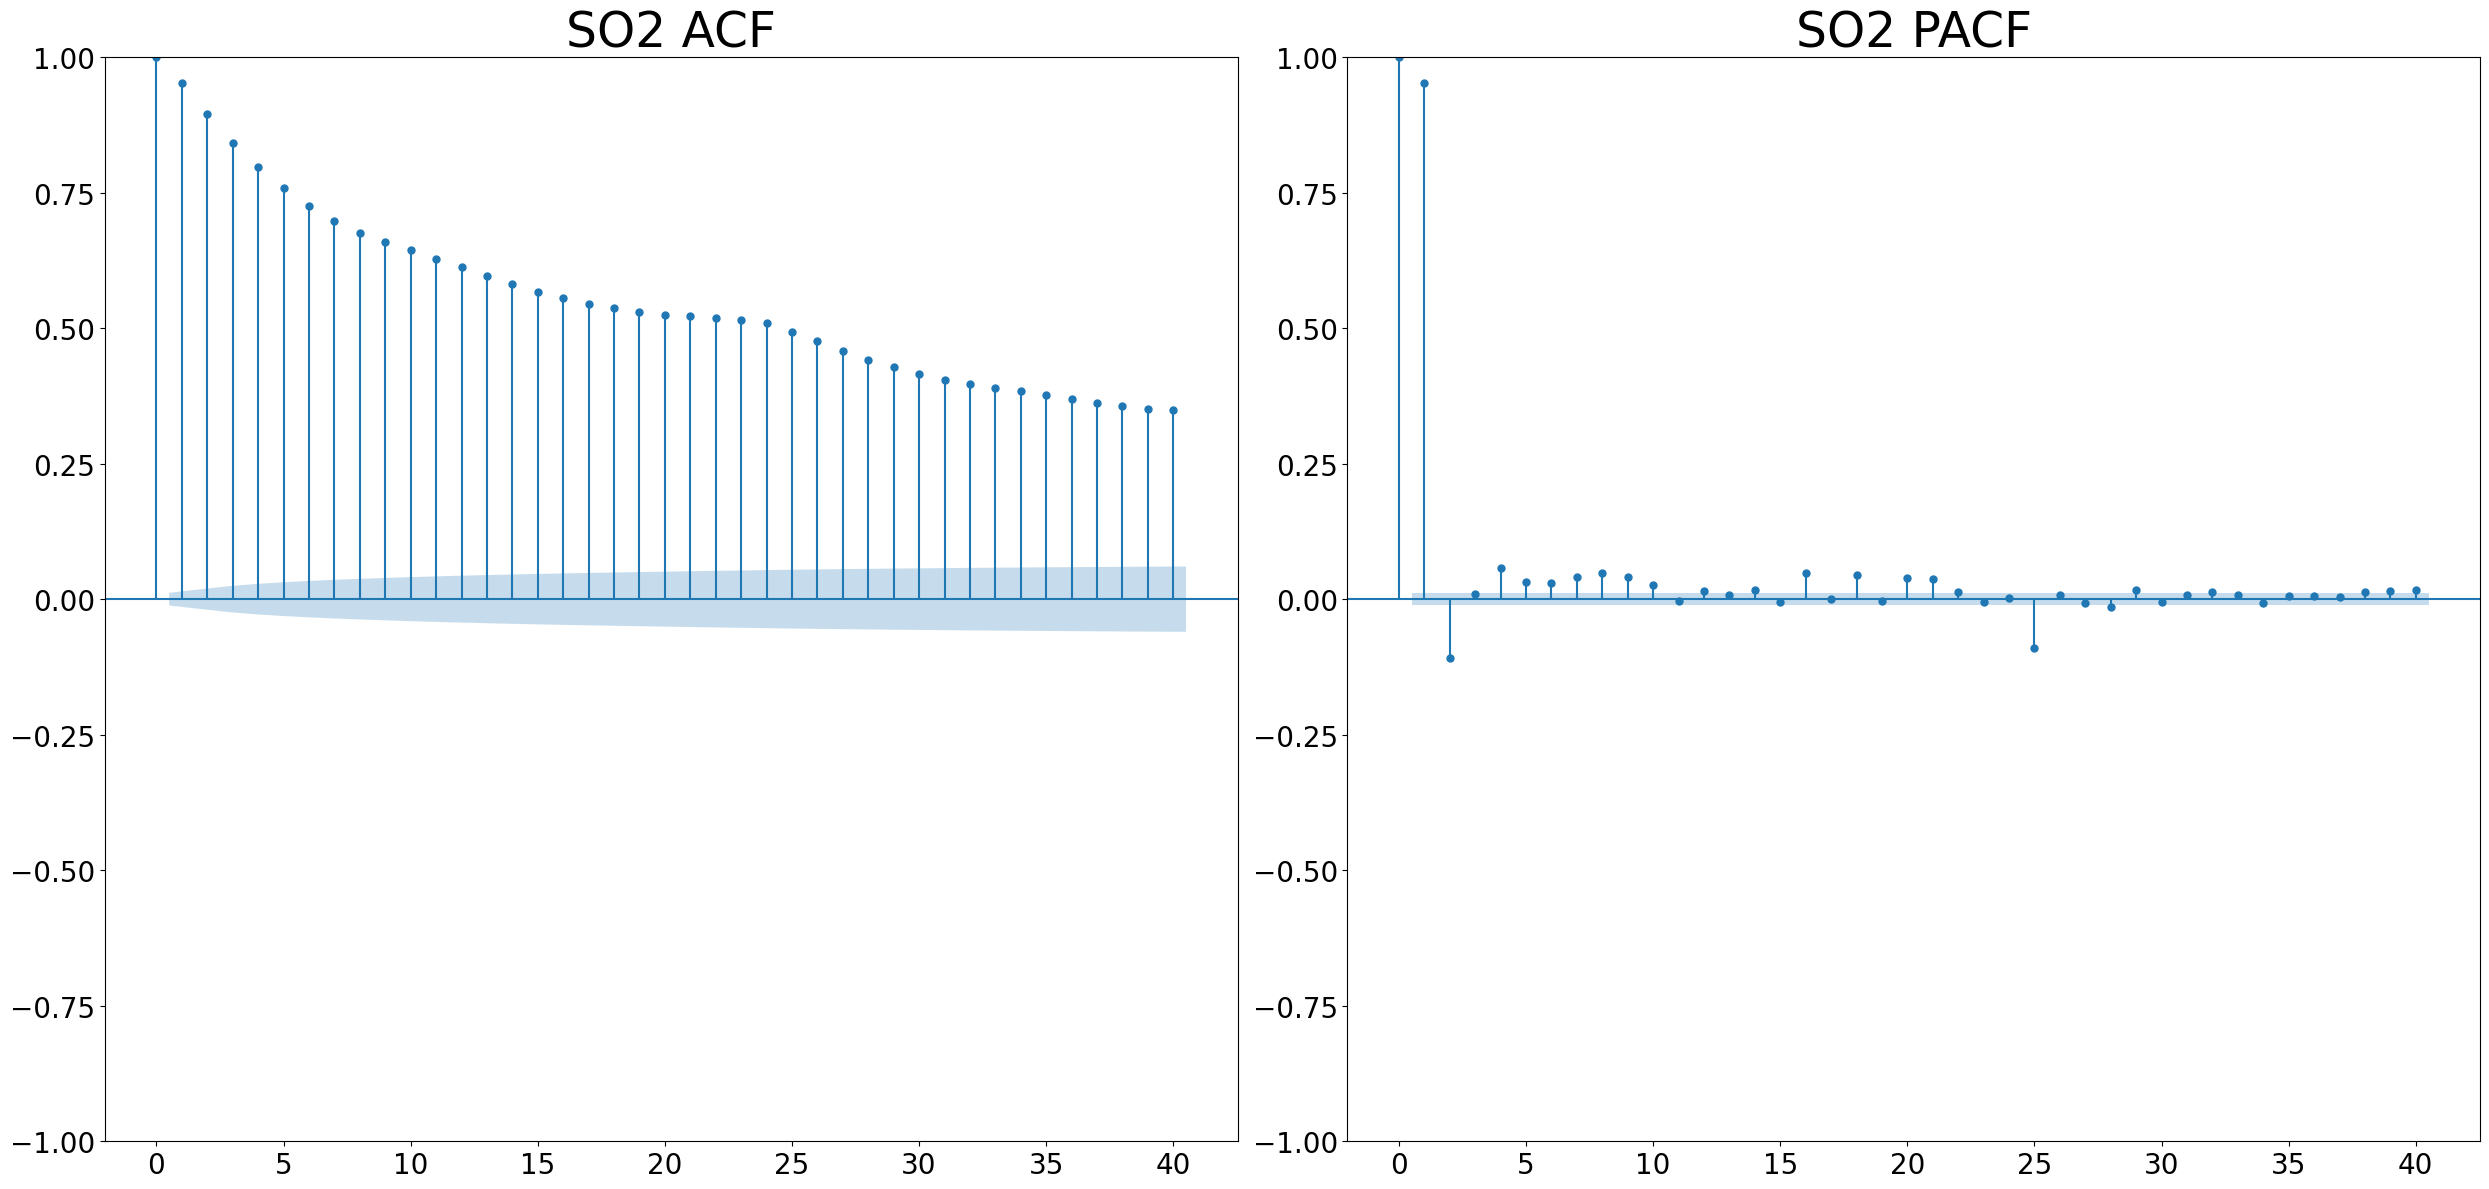

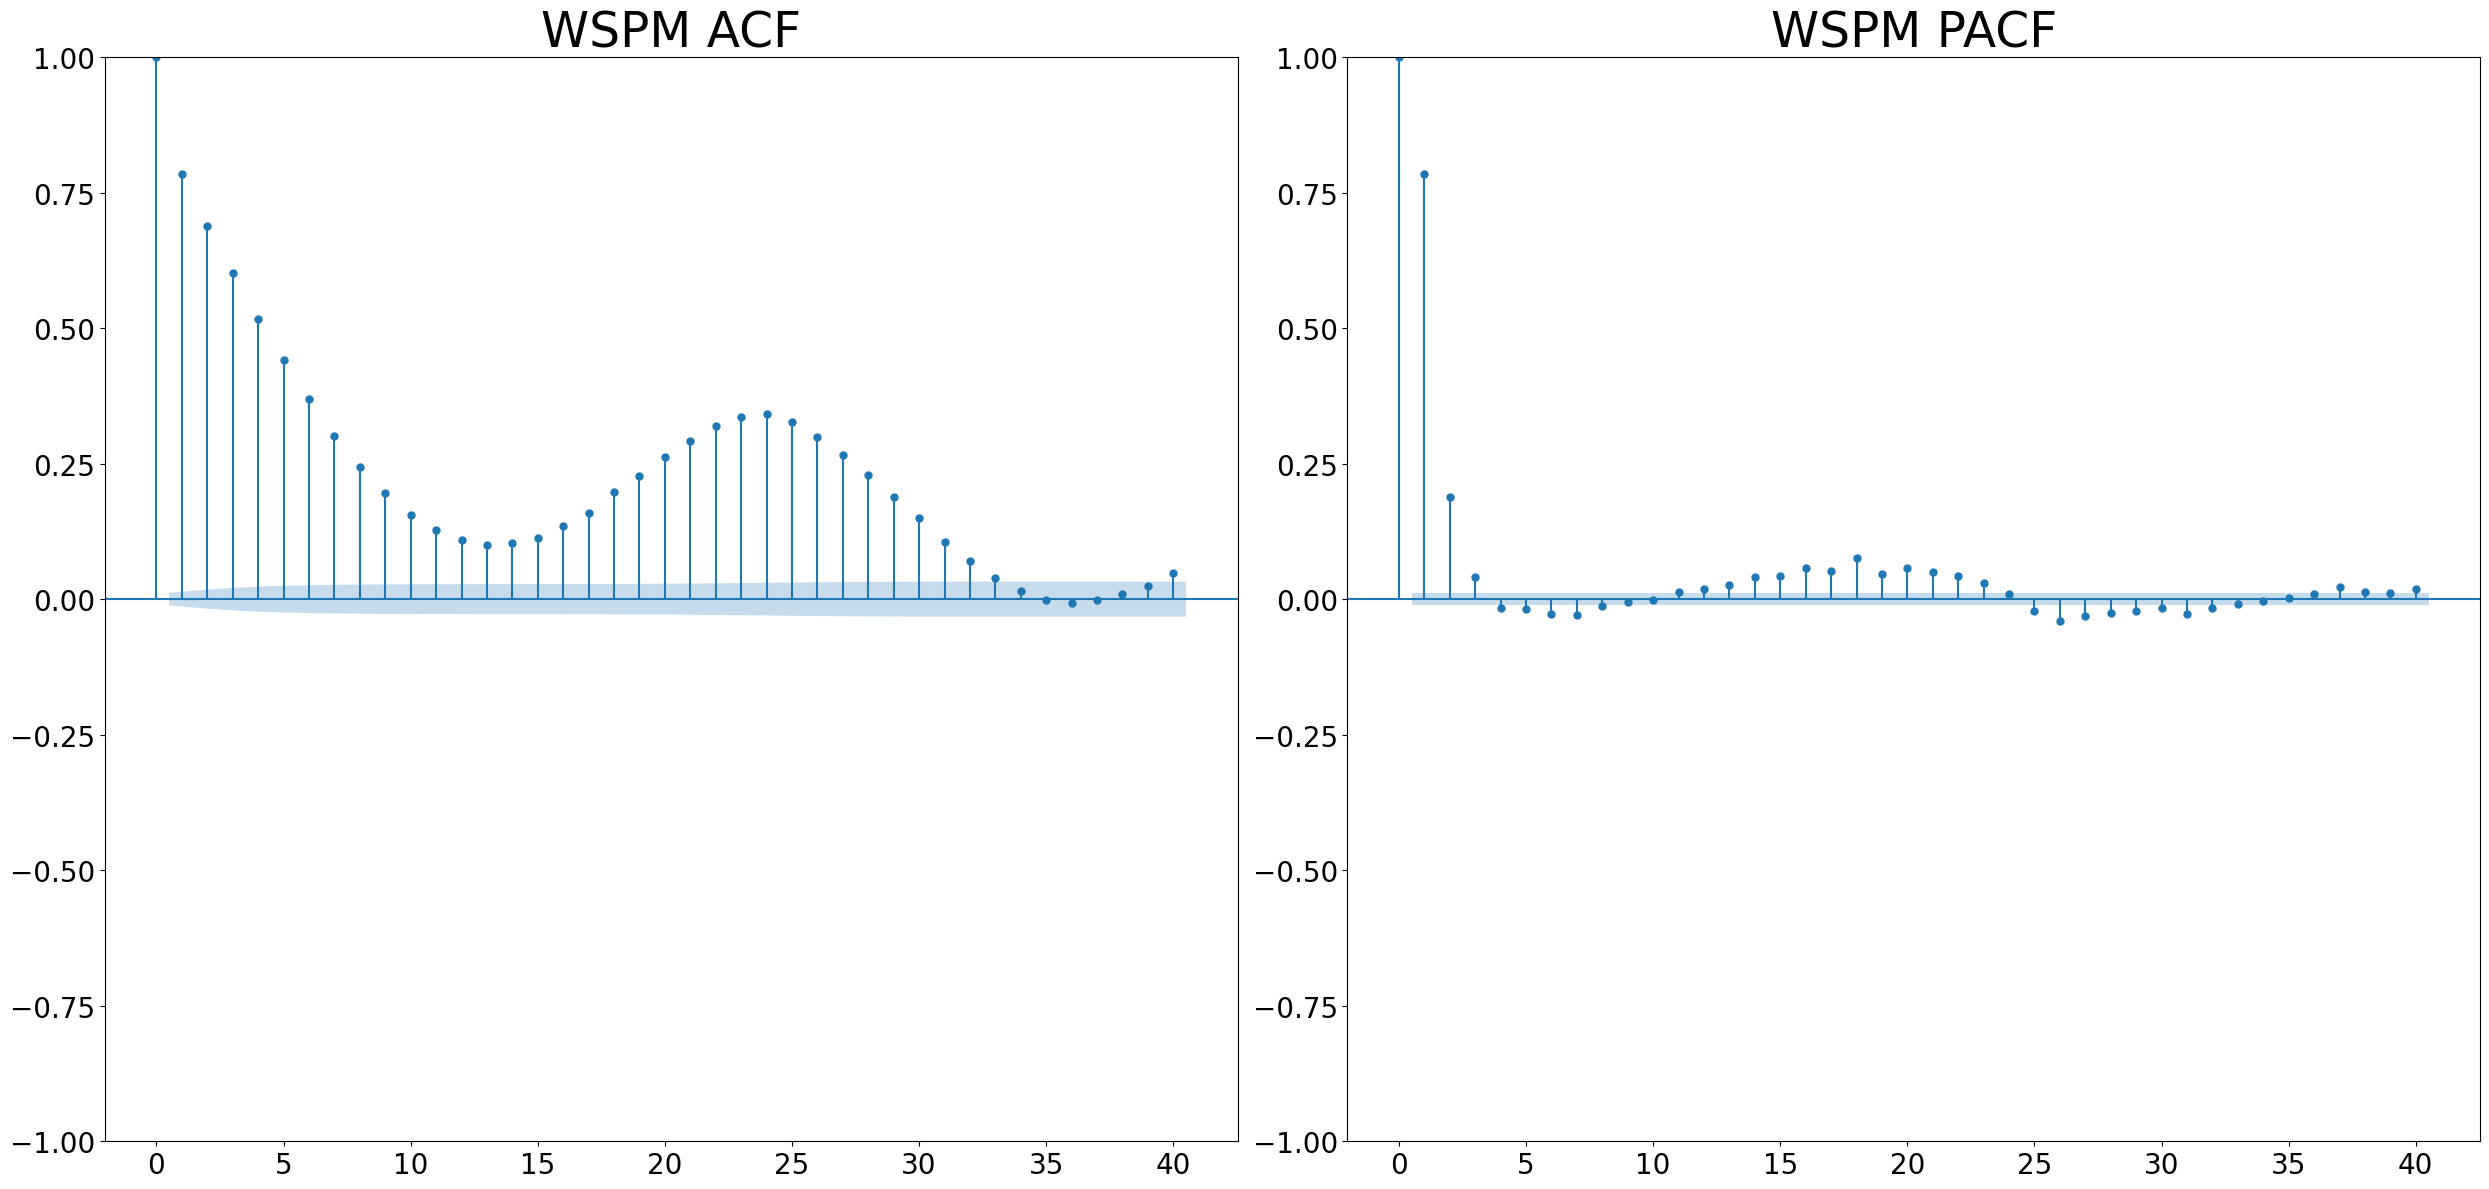

In [91]:
for f in sensible_features:
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(25, 12))

    plot_acf(df_train_class[f], lags=40, ax=axes[0])
    plot_pacf(df_train_class[f], lags=40, ax=axes[1])

    # title font size
    axes[0].set_title(f'{f} ACF', fontsize=35)
    axes[1].set_title(f'{f} PACF', fontsize=35)

    # axis font size
    axes[0].tick_params(axis='both', which='major', labelsize=20)
    axes[1].tick_params(axis='both', which='major', labelsize=20)

    plt.tight_layout()
    plt.show()

No feature is **both** stationary **and** has a flat `ACF`. All of them are considered.

Huge uneven spikes far beyond the confidence interval (statistical significance of the correlations at different time lags) confirm the `Ljung-Box test` output. We do have to model the structure:

- `PM2.5_miss` - AR(1). Classic autoregression process when each value depends on the one before it. Evidence: ACF decays slowly, PACF abruptly cuts off after certain value. The modelling: lagged target (1)
- `CO` - AR(1). Same as `PM2.5`. The modelling: lagged `CO` (1)
- `DEWP` - AR(1). Same as `PM2.5`. The modelling: lagged `DEWP` (1)
- `NO2` - ARMA(1, 3). Autoregressive moving average process when both ACF and PACF have features of AR and MA. Evidence: both gradually tail off + abruptness in PACF. The modelling: lagged `NO2` (1) + smoothed/rolling (3).
- `PRES` - ARMA(1,5). Same as `NO2`, but PACF shows oscillation. The modelling: lagged `PRES` (1), smoothed/rolling (5)
- `SO2` - AR(1). Same as `PM2.5`. The modelling: lagged `SO2` (1)
- `WSPM` - ARMA(1, 3). The modelling: lagged `WSPM` (1) + smoothed/rolling (3)
- `PM10` - AR(1). Same as `PM2.5`. The modelling: lagged `PM10` (1)
- `O3` - ARMA(1, 6). The modelling: lagged `O3` (1) + smoothed/rolling (6)

The goal is to eliminate strong positive autocorrelation in residuals by adding as few features as possible. Attempting lag features first while using greedy forward set election in combinations is considered.

In [ ]:
ljungbox_lags_df = pick_ljungbox_lags_for_classification(df_train_class, sensible_features, CLASS_TARGET, 
                                        lag_degree=1, max_combo_size=4, weights=weights)

ljungbox_lags_df.head(15)

,combo,lb_pvalue,lb_stat,acf_1,auc,cand_len,max_vif_col,max_vif_score,abs_acf_1
0,"(PM2.5_miss,)",1.594660e-156,814.737021,-0.000088,0.892667,1,year,5.839572,0.000088
1,"(SO2,)",0.000000e+00,210953.180028,0.033853,0.791497,1,year,11.315229,0.033853
2,"(CO,)",0.000000e+00,209889.947189,0.039951,0.791271,1,year,8.319087,0.039951
3,"(WSPM,)",0.000000e+00,208909.027525,0.048914,0.792388,1,year,5.895734,0.048914
4,"(DEWP,)",0.000000e+00,209772.192959,0.049589,0.792459,1,year,122.158670,0.049589
5,"(PRES,)",0.000000e+00,209692.226745,0.050042,0.792631,1,year,113.210109,0.050042
6,"(NO2,)",0.000000e+00,210029.084372,0.050542,0.792042,1,year,9.817290,0.050542
7,"(O3,)",0.000000e+00,210348.999048,0.052123,0.792683,1,year,12.622590,0.052123
8,"(PM10,)",0.000000e+00,209524.183110,0.055674,0.792719,1,year,7.577291,0.055674
9,"(PM2.5_miss, NO2)",9.932025e-156,810.977313,-0.000082,0.893173,2,year,9.820558,0.000082


Diagnostics used together to determine the best set of lagged features enough to state that autocorrelation will be resolved with their addition:
- `Ljung–Box p > 0.05` (can be violated for big data)
- `|acf1| < 0.10-0.15`
- `AUC` that doesn’t collapse (still reasonably above prevalence baseline)
- least amount of added lags (adding another lag gives negligible improvement in AUC or out-of-sample metrics)

If nothing meets that, we prefer the combo that minimizes `|acf1|` while keeping `AUC` stable and check `ACF`/`PACF`. If autocorrelation is not resolved still, we are going into rolling / smoothing features.

The best combination is the lagged target on its own - `PM2.5_miss_lagged_1`. Although the `p-value` is extremely small - `1.594660e-156` (degraded because of the scaling by a large amount of samples), `AUC`, nevertheless, is relatively high - `0.89`, `VIF is < 10` and `|acf1|` = `0.000088` is extremely small, which is most important, because now, when we plot `ACF` and there is no huge spikes anymore, it means we have successfully modelled the structure and may conclude that this assumption holds true.

In [66]:
# 1. applying the lags
cols_to_lag = [CLASS_TARGET]

for col in cols_to_lag:
    df_train_class[f"{col}_lag_{1}"] = df_train_class[col].shift(1)

df_train_class = df_train_class.iloc[1:] # drop the first row to discard the NaN

X_train = df_train_class.drop(columns=[CLASS_TARGET])
y_train_class = df_train_class[CLASS_TARGET]

# 2. recalculate the weights
n_missing = y_train_class.sum()
n_non_missing = len(y_train_class) - n_missing

weight_missing = 0.5 / (n_missing / len(y_train_class))
weight_non_missing = 0.5 / (n_non_missing / len(y_train_class))

weights = np.where(y_train_class == 1, weight_missing, weight_non_missing)

# 3. refit the model
X = sm.add_constant(X_train)  # predictors

cov_struct = Independence() 
groups = np.ones(len(y_train_class))

model = sm.GEE(
    endog=y_train_class,
    exog=X,
    groups=groups,
    family=sm.families.Binomial(),
    cov_struct=cov_struct,
    weights=weights
)

res = model.fit(start_params=None, maxiter=2000)

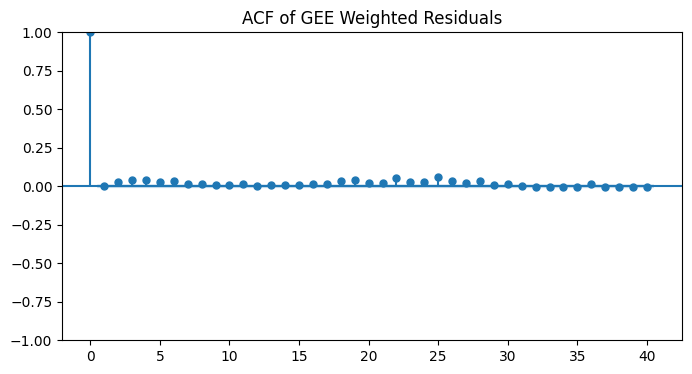

In [93]:
# compute weighted residuals: raw + weighted Pearson (not using res.resid_pearson specifically to calculate weighted Pearson - for custom weights)
eps = 1e-12 # to account for zero division
p_hat = res.fittedvalues # train predictions
resid = (y_train_class - p_hat).astype(float) # classification residuals
p_hat = np.clip(p_hat, eps, 1 - eps) # replace zeroes with epsilon
pearson_resid_weighted = resid / np.sqrt(weights * p_hat * (1 - p_hat) + eps)

# Plot ACF
fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(pearson_resid_weighted, lags=40, ax=ax)
ax.set_title("ACF of GEE Weighted Residuals")
plt.show()

The `ACF` plot shows no visible structure: all correlations are small and within the significance bounds. 
- The lag-1 autocorrelation is below the `0.10` threshold.
- Classification performance (`AUC`, `accuracy` > `0.8`) is stable.
- The `Ljung–Box` `p-value` tends to 0 because of the very large sample size

There is no statistically significant autocorrelation left in residuals; the model has captured the temporal structure. Although the `Ljung–Box test`'s `p-value` is close to zero (likely due to the very large sample size), the residual `ACF` shows no significant spikes, and the lag-1 autocorrelation falls below 0.1. Together, this indicates that temporal autocorrelation has been adequately addressed. Therefore, the residuals can be considered approximately white noise, supporting the adequacy of the model specification.

In [94]:
y_pred_class = (p_hat >= 0.5).astype(int)  # threshold = 0.5
acc = accuracy_score(y_train_class, y_pred_class)
auc = roc_auc_score(y_train_class, p_hat)

print("Accuracy:", acc)
print("ROC AUC:", auc)

Accuracy: 0.9755436720142603
ROC AUC: 0.9491812092202759


The accuracy is on point. Thus, the model understands the data well and its coefficients are reliable given that they are stable.

#### Heteroscedasticity

As mentioned before, thanks to the robust estimator, `GEE` already uses robust (sandwich) `SE`s and a working correlation.

#### Bootstrap coefficient stability

`VIF` and `ACF` tells about multicollinearity and serial correlation, but they don’t show whether the actual coefficient estimates are stable (i.e., if small changes in data would flip their sign or magnitude). If we had unstable unresolved `VIF` values that we weren't able to resolve, this assumption would tell if they are worth relying on.

The sandwich (robust) covariance estimator in `GEE` protects standard errors and inference against heteroscedasticity in the data (they “down-weight” extreme variability so that `p-values` and confidence intervals remain valid and don't collapse), but it does not prevent small, unstable signals (close to `0`) from being indistinguishable from noise. We are utilizing moving block bootstrap stability with overlapping window for that (to account for time series autocorrelation; not to break it).

The observations are being bootstrapped into blocks of `24` signifying a day with `2000` sets for the most reliable results.

In [95]:
vif_table = perform_VIF(data_frame_no_nulls=X_train, 
            encoded_predictors=list(X_train.columns), 
            target=CLASS_TARGET   
            )

vif_table.head(10)

,feature,VIF
26,DEWP_per_PRES,3.843860
7,PRES,3.734868
23,TEMP_residual,3.679738
4,NO2,3.382174
5,CO,2.930358
6,O3,2.750148
15,wd_binned_NE,2.473014
24,month_cos_residual,2.453122
14,wd_binned_N,2.369088
2,PM10,2.287840


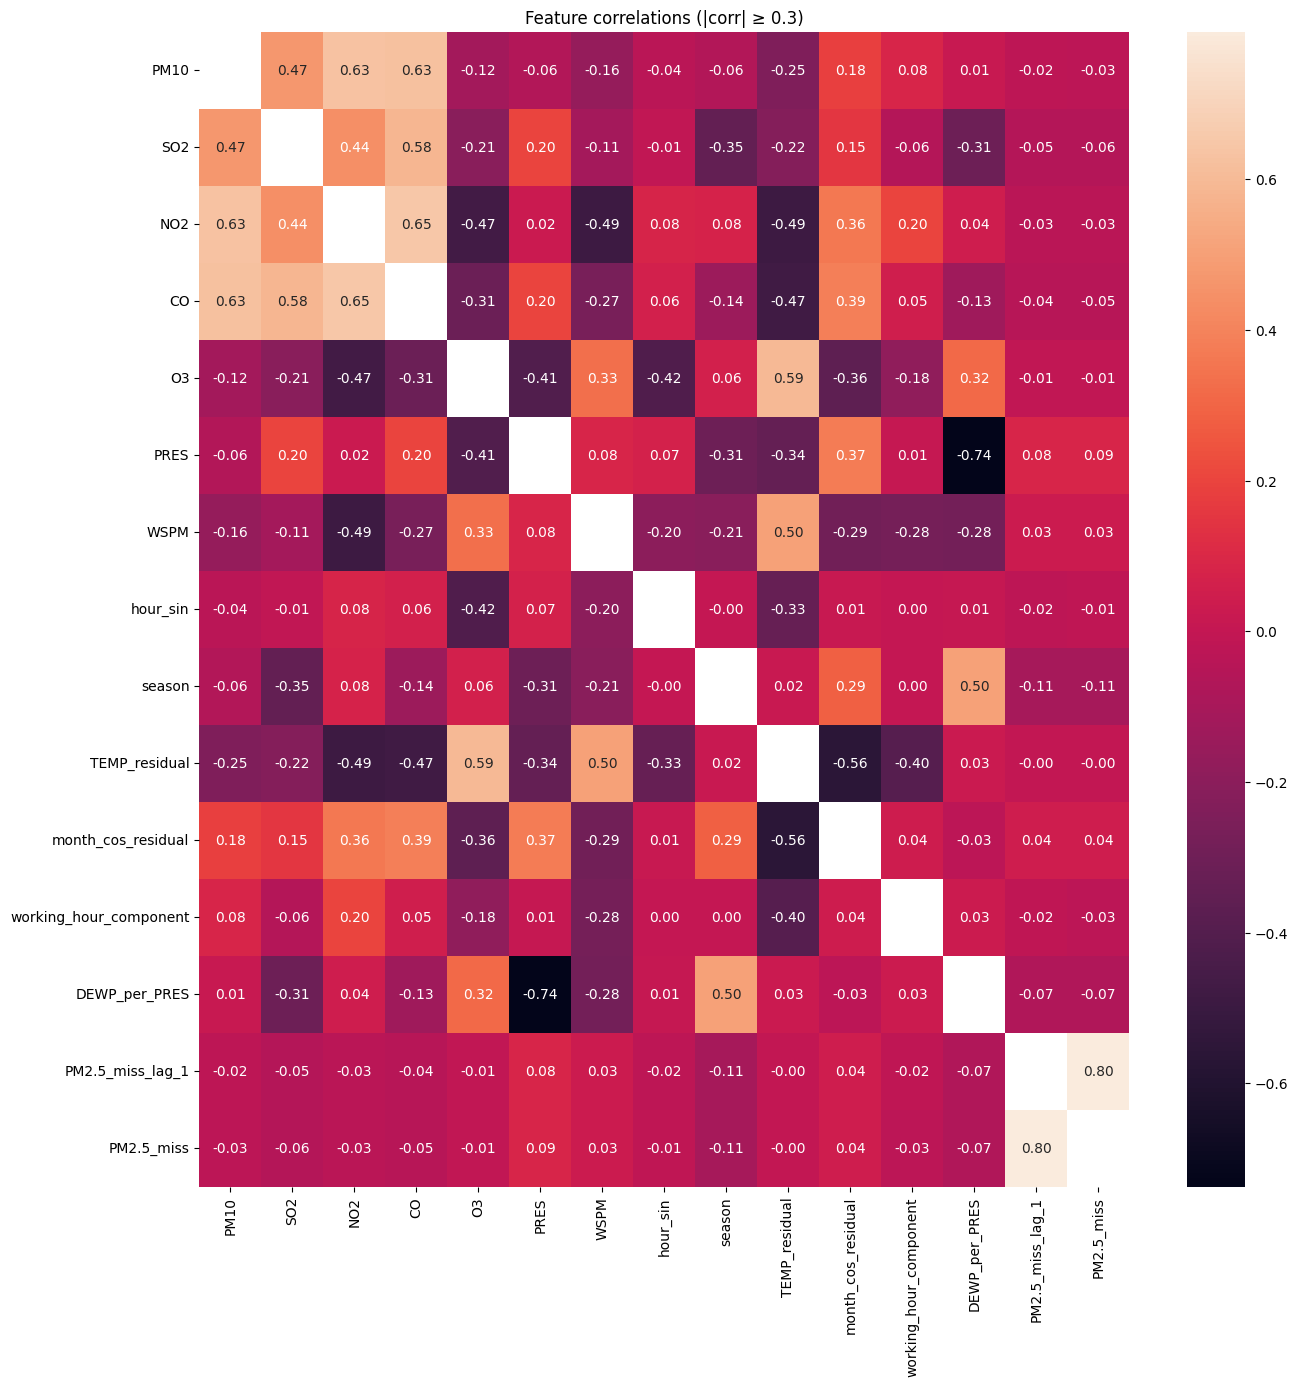

,abs_corr,has_nulls
PM2.5_miss_lag_1,0.796007,False
season,0.106617,False
PRES,0.085435,False
DEWP_per_PRES,0.068880,False
day_sin,0.061386,False
SO2,0.059518,False
CO,0.047661,False
month_cos_residual,0.041742,False
NO2,0.033517,False
year,0.032539,False


In [96]:
df_train_class = pd.concat([X_train, y_train_class], axis=1)
correlations = plot_correlations(df_train_class, df_train_class.columns.tolist(), f'Feature correlations', 0.3)

get_corr_null_info_for_a_feat(df_train_class, CLASS_TARGET, correlations, df_train_class.columns.tolist())

To account for block length data sensitivity, we also average the scores across multiple lengths: 12 (half a day), 24 ( day), 72 (3 days), 168 (a week).

In [97]:
multi_block_boots_coeffs_dfs = []
for block_len in [12, 24, 72, 168]:
    print(f"Block {block_len} executing...")
    multi_block_boots_coeffs_dfs.append(bootstrap_coefficients(dataframe=df_train_class, 
                        target=CLASS_TARGET, 
                        predictors=list(df_train_class.columns), 
                        block_len=block_len,
                        n_boot=2000, # number of bootstrap samples
                        random_state=RANDOM_SEED))

Block 12 executing...
200/2000 bootstraps completed...
400/2000 bootstraps completed...
600/2000 bootstraps completed...
800/2000 bootstraps completed...
1000/2000 bootstraps completed...
1200/2000 bootstraps completed...
1400/2000 bootstraps completed...
1600/2000 bootstraps completed...
1800/2000 bootstraps completed...
2000/2000 bootstraps completed...
Block 24 executing...
200/2000 bootstraps completed...
400/2000 bootstraps completed...
600/2000 bootstraps completed...
800/2000 bootstraps completed...
1000/2000 bootstraps completed...
1200/2000 bootstraps completed...
1400/2000 bootstraps completed...
1600/2000 bootstraps completed...
1800/2000 bootstraps completed...
2000/2000 bootstraps completed...
Block 72 executing...
200/2000 bootstraps completed...
400/2000 bootstraps completed...
600/2000 bootstraps completed...
800/2000 bootstraps completed...
1000/2000 bootstraps completed...
1200/2000 bootstraps completed...
1400/2000 bootstraps completed...
1600/2000 bootstraps complet

In [98]:
combined_df = pd.concat(multi_block_boots_coeffs_dfs, axis=0) 
multi_block_boots_coeffs_df = combined_df.groupby(level=0).agg('median')
# filter to list the most unstable versions first
multi_block_boots_coeffs_df.sort_values(by=['relative_std', 'sign_consistency', 'coef_std'], ascending=[False, True, False])

,coef_mean,coef_std,relative_std,sign_consistency,ci_low,ci_high
feature,,,,,,
wd_binned_N,-0.000135,0.002122,16.227909,0.529250,-0.004172,0.003977
wd_binned_W,-0.000178,0.002802,15.834139,0.527250,-0.005452,0.005383
TEMP_residual,0.000022,0.000159,7.260480,0.561750,-0.000299,0.000322
hour_sin,0.000127,0.000919,7.097521,0.574000,-0.001764,0.001765
WSPM,-0.000185,0.000904,4.904676,0.588000,-0.001921,0.001625
wd_binned_SW,-0.000623,0.002213,3.555224,0.608500,-0.004992,0.003626
is_weekend,-0.000512,0.001762,3.451266,0.615250,-0.004043,0.002846
O3,0.000008,0.000026,3.240197,0.632500,-0.000046,0.000057
wd_binned_NE,0.000589,0.001844,3.128876,0.626000,-0.002991,0.004202


The interpretation rules being applied:
- `relative_std` > `1.0` means the standard deviation is more than its whole mean (unstable), ideally should be < `0.5`;
- the confidence interval crosses `0` and therefore doesn't let us reject that it may have no impact on predictions, which is also supported if its `coeff_mean` is close to `0`;
- `sign_consistency` < `0.7-0.8` (ideally `0.9-1.0`)

Based on the declared guidelines, the list of reliable, stable and interpretable features is as follows:
- `PM2.5_miss_lag_1`
- `SO2`
- `season`
- `CO`
- `working_hour_component`
- `month_cos_residual`
- `day_sin`

The rest of the features have no to very little impact, but must stay in the model for the context to remain. They would also be best to stay in a predictive model due to variance-balancing reasons.

## Interpretation: coefficient extraction + visualization

- `PM2.5_miss_lag1`: The missingness strongly depends on the previous value, if it begins, it most likely retains in the following value.
- `SO2`, `CO`, `working_hour_component` with their negative coefficients tell us that during working hours, it is less likely for the missing value to occur. Possible explanation is that it's either easier for the sensors to capture pollutants (there are way more accompanying compounds from car emissions during rush hour in the air, for example) or the sensors are under closer observation during daytime.
- `day_sin`, `month_cos_residual` and `season` also tell us that seasonality is involved. Possible reasons: weather conditions affect sensors (e.g. humidity in winter), maintenance schedules (quarterly/monthly), power outages etc.

In [99]:
stable_features = ['PM2.5_miss_lag_1', 'SO2', 'CO', 'day_sin', 'working_hour_component', 'month_cos_residual', 'season']

In [101]:
scaler_stds_df = pd.read_csv("std_scaler_stds.csv")
scaler_stds_df.set_index("col", inplace=True)
scaler_stds_df

,std
col,
year,0.975414
PM10,94.609868
SO2,23.821079
NO2,36.110527
CO,1144.774364
O3,54.693329
PRES,10.278985
RAIN,0.506552
WSPM,1.234778


In [102]:
df_train_class.columns

Index(['year', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'PRES', 'RAIN', 'WSPM',
       'hour_sin', 'day_sin', 'day_cos', 'dayofweek_cos', 'wd_binned_N',
       'wd_binned_NE', 'wd_binned_NW', 'wd_binned_S', 'wd_binned_SE',
       'wd_binned_SW', 'wd_binned_W', 'season', 'is_weekend', 'TEMP_residual',
       'month_cos_residual', 'working_hour_component', 'DEWP_per_PRES',
       'PM2.5_miss_lag_1', 'PM2.5_miss'],
      dtype='object')

In [103]:
# --- Step 1. Extract coefficients (ignoring intercept)
coef_df = multi_block_boots_coeffs_df.drop('const', axis=0)
X = df_train_class[stable_features]   # predictors aligned

numerical_features = ['year', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'PRES', 'RAIN', 'WSPM', 
                      'hour_sin', 'day_sin', 'day_cos', 'dayofweek_cos', 'TEMP_residual', 'month_cos_residual', 'working_hour_component',
                      'DEWP_per_PRES']

# --- Step 2. Mapping coefficient back to raw scale
scaled_coeffs = []
odds_ratios = []
odds_ci_low = []
odds_ci_high = []
percentages = []
for feat in stable_features:
    if feat in numerical_features:
        raw_std = scaler_stds_df.loc[feat]['std'] if feat in scaler_stds_df.index else 1
        coef_per_unit = coef_df.loc[feat, 'coef_mean'] / raw_std # new coefficient that is interpretable per real unit of the feature
        CI_low_per_unit = coef_df.loc[feat, 'ci_low'] / raw_std
        CI_high_per_unit = coef_df.loc[feat, 'ci_high'] / raw_std
    else: # binaries/dummies were not scaled
        coef_per_unit = coef_df.loc[feat, 'coef_mean']
        CI_low_per_unit = coef_df.loc[feat, 'ci_low'] 
        CI_high_per_unit = coef_df.loc[feat, 'ci_high']

    odds_ratio_per_unit = np.exp(coef_per_unit) # odds of success
    scaled_coeffs.append(coef_per_unit)
    odds_ratios.append(odds_ratio_per_unit)

    CI_low_raw = np.exp(CI_low_per_unit)
    CI_high_raw = np.exp(CI_high_per_unit)

    odds_ci_low.append(CI_low_raw)
    odds_ci_high.append(CI_high_raw)

    percentages.append((odds_ratio_per_unit-1)*100)

# --- Step 5. Assemble dataframe
df_odds = pd.DataFrame({
    'feature': stable_features,
    'scaled_coef': scaled_coeffs,
    'odds': odds_ratios, # how much the odds are multiplied
    'pecentage': percentages,
    'odds_ci_low': odds_ci_low,
    'odds_ci_high': odds_ci_high
})

# --- Step 6. Sort by effect size
df_odds['abs_scaled_coef'] = df_odds['scaled_coef'].abs()
df_odds = df_odds.sort_values(by='abs_scaled_coef', ascending=False)
df_odds

,feature,scaled_coef,odds,pecentage,odds_ci_low,odds_ci_high,abs_scaled_coef
0,PM2.5_miss_lag_1,0.779009,2.179312,117.931237,2.009231,2.307618,0.779009
5,month_cos_residual,0.009139,1.009181,0.918110,1.001818,1.015566,0.009139
6,season,-0.006960,0.993064,-0.693559,0.990011,0.996387,0.006960
4,working_hour_component,-0.006928,0.993096,-0.690409,0.989554,0.996355,0.006928
3,day_sin,-0.002520,0.997483,-0.251714,0.995100,0.999934,0.002520
1,SO2,-0.000010,0.999990,-0.001022,0.999985,0.999994,0.000010
2,CO,-0.000000,1.000000,-0.000000,1.000000,1.000000,0.000000


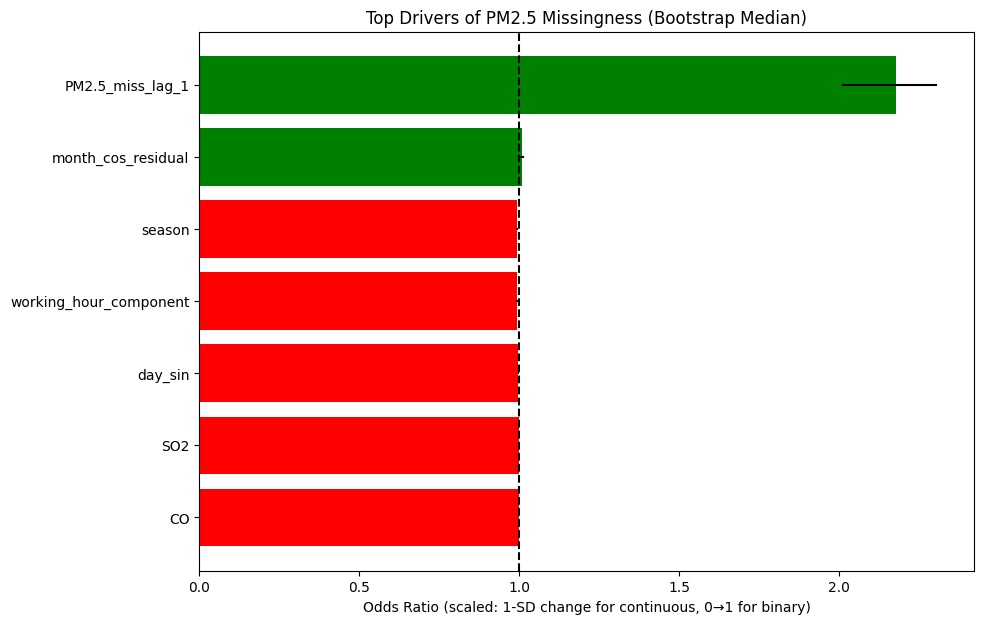

In [104]:
plt.figure(figsize=(10, 7))
colors = ['green' if x > 1 else 'red' for x in df_odds['odds']]
plt.barh(df_odds['feature'], df_odds['odds'], color=colors, xerr=[
    df_odds['odds'] - df_odds['odds_ci_low'],
    df_odds['odds_ci_high'] - df_odds['odds']
])
plt.axvline(1, color='black', linestyle='--')
plt.xlabel("Odds Ratio (scaled: 1-SD change for continuous, 0→1 for binary)")
plt.title("Top Drivers of PM2.5 Missingness (Bootstrap Median)")
plt.gca().invert_yaxis()
plt.show()

## Save the data and the model

In [105]:
df_train_class.to_csv(os.path.join(data_folder_path, 'processed', "02_df_train_class_preprocessed.csv"), index=True, index_label='datetime')

gee_results = {
    "params": res.params,
    "bse": res.bse,
    "cov_params": res.cov_params(),
    "pvalues": res.pvalues,
    "model_info": {
        "family": str(res.model.family),
        "cov_struct": str(res.model.cov_struct),
        "exog_names": res.model.exog_names,
        "endog_name": res.model.endog_names,
    }
}

joblib.dump(gee_results, os.path.join(data_folder_path, 'models', "GEE_null_interpretation.pkl"))

['data\\models\\GEE_null_interpretation.pkl']

## Conclusion

In the context of the model, given the range of years [2013; 2016], the patterns of missingness are as follows:
- if `PM2.5` missed the previous hour, the `odds` of it being missing again are multiplied by `2.18` (+118%; `CI`: [2.01; 2.31]). That’s a big effect.
- in certain times of `month`, not explained by `DEWP`, the `odds` of missingness are about `1.01` times higher (+0.9%;  `CI`: 1.001–1.02). Very small effect.
- in some `season`s, `odds` are about `0.993` times lower (-0.69%; `CI`: 0.99–0.996). Reasonable effect.
- in `working hours`, the `odds` of missingness are about `0.993` times lower (-0.69%; `CI`: 0.989–0.996). Reasonable effect.
- in certain times of `day`, the `odds` of missingness are about `0.997` times lower (-0.25%; `CI`: 0.995–0.999).
- each 1 ug/m^3 increase in `SO2` reduces the `odds` of missingness by `0.99999`  (-0.001%; `CI`: 0.99998–0.99999). Essentially no effect.
- each 1 ug/m^3 increase in `CO` reduces the `odds` of missingness by `1` (-0.0000%; `CI`: 1.0–1.0). Completely negligible.